Notebook for core comparising of Motif Atlas (ref), MixMHCIIpred and NetMHCIIpan 

* Exact match 
* Shift tolerant match 
* Jaccard index
* Ancor state matches


In [1]:
base_dir = r"experiment_results\reordered_models"
base_models = [f"base_model_{i}" for i in range(4,10)]
new_models = [f"second_model_{i}" for i in range(4,10)]

experiments = base_models + new_models

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Read all models
import sys
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

METHOD = "hmm_pomegranate"
from hmm_logic_methods import  load_model
from hmm_visualization_methods import *
from training_parameters import *

import training_parameters
from data_reading_methods import *
#read and prepare data
def get_train_test_data(experiment_params :ExperimentParams, type_of_peptides= "binders"):
    data_params : DataScenarioParams = experiment_params.data_scenario_params
    data_scenario = data_params.data_scenario
    DATA_PATH = data_params.input_data_path
    TOTAL_SPLITS = data_params.splits_to_read
    print(f"Will read files from the folder {DATA_PATH}")
    assert data_scenario in ["IEDB_preprocessed", "simulated", "simulated_preprocessed", 'MixMHCpred']
    additional_return = list()
    if isinstance(data_params, PreprocessedIEDBDataParams):
        ALLELES = get_available_alleles(DATA_PATH)
        per_allele_per_kfold_per_length_binders_train = read_data(DATA_PATH,ALLELES, "train", type_of_peptides)
        per_allele_per_kfold_per_length_binders_test = read_data(DATA_PATH,ALLELES, "test", type_of_peptides)
        sample_allele = list(per_allele_per_kfold_per_length_binders_train.keys())[0]
        per_allele_df = join_dicts(per_allele_per_kfold_per_length_binders_train)
        for allele_name in ALLELES:
            per_allele_df[allele_name]['allele'] = allele_name
        assert len(per_allele_per_kfold_per_length_binders_train[sample_allele].keys()) >= TOTAL_SPLITS # check number of splits
        additional_return.append(per_allele_df)
    elif isinstance(data_params, SimulatedPreprocessedDataParams):
        ALLELES = get_available_alleles(DATA_PATH, do_not_parse_alleles=True)
        per_allele_per_kfold_per_length_binders_train = read_data(DATA_PATH,ALLELES, "train", type_of_peptides, do_not_parse_alleles=True)
        per_allele_per_kfold_per_length_binders_test = read_data(DATA_PATH,ALLELES, "test", type_of_peptides,do_not_parse_alleles=True)
        sample_allele = list(per_allele_per_kfold_per_length_binders_train.keys())[0]
        per_allele_df = join_dicts(per_allele_per_kfold_per_length_binders_train)
        for allele_name in ALLELES:
            per_allele_df[allele_name]['allele'] = allele_name
        assert len(per_allele_per_kfold_per_length_binders_train[sample_allele].keys()) >= TOTAL_SPLITS # check number of splits
        additional_return.append(per_allele_df)
    elif isinstance(data_params, SimulatedDataParams):
        simulated_exact_file = data_params.simulated_exact_file_name
        dummy_allele_name = data_params.dummy_allele_name
        simulated_scenario = data_params.simulated_scenario
        SIMULATED_DATA_PATH = f"{DATA_PATH}/{simulated_scenario}/{simulated_exact_file}"
        ALLELES = [dummy_allele_name]
        per_allele_df = dict()
        # For now just read the same data multiple times for alleles/splits
        for allele_name in ALLELES:
            allele_df = pd.read_csv(SIMULATED_DATA_PATH, sep=";")
            list_dfs = [allele_df.copy() for i in range(TOTAL_SPLITS)]
            for split_num, split_df in enumerate(list_dfs):
                split_df['split'] = split_num
                split_df['allele_name'] = allele_name
                result_allele_df = pd.concat(list_dfs)
            per_allele_df[allele_name] = result_allele_df
            result_allele_df['length'] = split_df.peptide.str.len()
            TARGET_LENGTHS = list(split_df['length'].unique())
        # split data into dicts
        per_allele_per_kfold_per_length_binders_train = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        per_allele_per_kfold_per_length_binders_test =  split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        additional_return.append(per_allele_df)
    elif isinstance(data_params, MixMHCpredDataParams):
        mixture_name = data_params.mixmhc_mixture_name
        dummy_allele_name = data_params.dummy_allele_name
        df = pd.read_csv(DATA_PATH, sep=';')
        print(df.columns)
        df = df.loc[
            df.Peptide.str.match("^[ACDEFGHIKLMNPQRSTVWY]+$")
        ]
        print("Total table length", len(df))
        #Filter out selected mixture
        df = df.loc[df.Sample_IDs.str.split(', ').apply(lambda x: mixture_name in x),]
        print("Filtered for given mixture", len(df))
        sample_data = pd.DataFrame(
            {"peptide": df.Peptide.values,
             "old_sample_id": df.Sample_IDs,
             "sample_id": mixture_name,
             "mixmhc_predicted_mixed_alleles": df.Allele.values})

        list_dfs = [sample_data.copy() for i in range(TOTAL_SPLITS)]
        per_allele_df = dict()
        allele_name = "d_" + dummy_allele_name
        ALLELES = [allele_name]
        for allele_name in ALLELES:
            for split_num, split_df in enumerate(list_dfs):
                split_df['split'] = split_num
                split_df['allele'] = allele_name
                split_df['length'] = split_df.peptide.str.len()
            result_allele_df = pd.concat(list_dfs)
            result_allele_df = result_allele_df.drop_duplicates(subset=['peptide'])
            TARGET_LENGTHS = list(split_df['length'].unique())
            per_allele_df[allele_name] = result_allele_df
        per_allele_per_kfold_per_length_binders_train = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        per_allele_per_kfold_per_length_binders_test = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        additional_return.append(per_allele_df)
        additional_return.append(df)
    return per_allele_per_kfold_per_length_binders_train,  per_allele_per_kfold_per_length_binders_test, additional_return

from pomegranate.io import BatchedDataGenerator, SequenceGenerator
def create_char_arrays(peptide_sequences):
    return np.array([[char for char in peptide] for peptide in peptide_sequences], dtype=object)

def prepare_split_data_separeted_length(per_length_data, per_length_weights, per_length_test_data, target_lengths):
    binders_array = np.array([per_length_data[length][i] for length in target_lengths
                              for i in range(len(per_length_data[length]))], dtype=object)
    weights_array = np.array([per_length_weights[length][i] for length in target_lengths
                               for i in range(len(per_length_weights[length]))], dtype=object)
    binders_test_array = np.array([per_length_test_data[length][i] for length in target_lengths
                                   for i in range(len(per_length_test_data[length]))], dtype=object)
    return binders_array, weights_array, binders_test_array




def read_all_models(models_dir, history=True):
    parsed_alleles = os.listdir(models_dir)
    print(f"Found {parsed_alleles}")    
    per_allele_per_split_per_run_model = dict()
    per_allele_per_split_per_run_history = dict() if history else None
    
    for parsed_allele in parsed_alleles:
        per_allele_per_split_per_run_model[parsed_allele] = dict()
        if history:
            per_allele_per_split_per_run_history[parsed_allele] = dict()
        
        allele_dir = f"{models_dir}/{parsed_allele}"
        for split_string in os.listdir(allele_dir):
            per_allele_per_split_per_run_model[parsed_allele][split_string] = dict()
            if history:
                per_allele_per_split_per_run_history[parsed_allele][split_string] = dict()
            
            split_dir = f"{allele_dir}/{split_string}/"
            for run_string in os.listdir(split_dir):
                run_dir = f"{split_dir}{run_string}"
                run_index = run_string.split("_")[0]
                model = load_model(split_dir, run_string)
                per_allele_per_split_per_run_model[parsed_allele][split_string][run_index] = model
                
                if history:
                    history_data = pd.read_csv(os.path.join(run_dir, "history.csv"), index_col=False, header=0)
                    per_allele_per_split_per_run_history[parsed_allele][split_string][run_index] = history_data

    if history:
        return per_allele_per_split_per_run_model, per_allele_per_split_per_run_history
    else:
        return per_allele_per_split_per_run_model


def score_binder(peptide, model_b, model_nb): 

    logp_1, _ = model_b.viterbi(np.array(list(peptide)))
    logp_1 = logp_1/len(peptide)
    logp_0, _ = model_nb.viterbi(np.array(list(peptide)))
    logp_0 = logp_0/len(peptide)
    score = np.exp(logp_1)/(np.exp(logp_1)+np.exp(logp_0))
    return score


import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_median_scores_for_top_models(per_name_models, peptides, models_fraction=0.25):
    runs = list(per_name_models.keys())
    num_models = max(int(len(runs) * models_fraction), 1)
    scores = np.zeros((len(peptides), num_models))
    
    for i, run in enumerate(runs[:num_models]):
        model = per_name_models[run]
        scores[:, i] = [model.log_probability(peptide) / len(peptide) for peptide in peptides]
    
    return np.median(scores, axis=1)

def prepare_peptides_data(test_data_b, test_data_nb, allele, split):
    peptides = []
    y_true = []
    
    for length, peptides_list in test_data_b.get(allele, {}).get(split, {}).items():
        peptides.extend(peptides_list)
        y_true.extend([1] * len(peptides_list))
    
    for length, peptides_list in test_data_nb.get(allele, {}).get(split, {}).items():
        peptides.extend(peptides_list)
        y_true.extend([0] * len(peptides_list))
    
    return peptides, y_true

def calculate_scores_for_allele_split(runs_b, runs_nb, peptides):
    if not peptides:
        return np.array([])
    
    logp_1 = get_median_scores_for_top_models(runs_b, peptides)
    logp_0 = get_median_scores_for_top_models(runs_nb, peptides)
    
    scores_adj = np.exp(logp_1) / (np.exp(logp_1) + np.exp(logp_0))
    return scores_adj

def evaluate_models(test_data_b, test_data_nb, per_name_models_b, per_name_models_nb):
    results, results_scores, y_true_all = {}, {}, {}
    
    for allele in set(test_data_b.keys()).union(test_data_nb.keys()):
        results[allele] = {}
        results_scores[allele] = {}
        y_true_all[allele] = {}
        allele_formated = allele.replace('-', '_').replace('*', '_').replace(':', '_').replace('/', '_')

        for split in set(test_data_b.get(allele, {}).keys()).union(test_data_nb.get(allele, {}).keys()):
            split_formated = f"s{split}"
            peptides, y_true = prepare_peptides_data(test_data_b, test_data_nb, allele, split)
            
            runs_b = per_name_models_b.get(allele_formated, {}).get(split_formated, {})
            runs_nb = per_name_models_nb.get(allele_formated, {}).get(split_formated, {})
            if not runs_b or not runs_nb:
                continue

            scores_adj = calculate_scores_for_allele_split(runs_b, runs_nb, peptides)
            
            results_scores[allele][split] = scores_adj.tolist()
            y_true_all[allele][split] = y_true
            
            if len(y_true) == len(scores_adj):
                results[allele][split] = {
                    "accuracy": accuracy_score(y_true, np.round(scores_adj)),
                    "precision": precision_score(y_true, np.round(scores_adj)),
                    "recall": recall_score(y_true, np.round(scores_adj)),
                    "f1": f1_score(y_true, np.round(scores_adj)),
                    "auc": roc_auc_score(y_true, scores_adj)
                }
    
    return results, results_scores, y_true_all

def save_json(data, filename, target_path):
    path = os.path.join(target_path, filename)
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    with open(path, 'w') as file:
        json.dump(data, file, indent=4)

#preapare data to test 
hmm_params = training_parameters.ExperimentParams(experiment_name="reordered_models")
hmm_params.model_training_params = training_parameters.SimpleModelClassIIParamsMixMHC()
hmm_params.data_scenario_params.input_data_path = r'C:\Projects\grandmaster\notebooks\alleles_data\simple_model_enrichment\per_length_per_kfold_split'
hmm_params.data_scenario_params.splits_to_read = 4
model_training_params = hmm_params.model_training_params
per_allele_per_kfold_per_length_binders_train, \
per_allele_per_kfold_per_length_binders_test, additional_data = get_train_test_data(hmm_params)
per_allele_per_kfold_per_length_non_binders_train, \
per_allele_per_kfold_per_length_non_binders_test, additional_data = get_train_test_data(hmm_params, "nonbinders")
PARSED_ALLELES = list(per_allele_per_kfold_per_length_binders_train.keys())
PARSED_ALLELES_NB = list(per_allele_per_kfold_per_length_non_binders_train.keys())

model_training_params.lengths_to_use = [12, 13, 14, 15, 16, 17, 18, 19, 20]
df = additional_data[0][list(additional_data[0].keys())[0]]

current_mix = ['HLA-DRB1*03:01', 'HLA-DRB1*07:01', 
               'HLA-DRB1*12:01', 'HLA-DRB1*11:01', 
               'HLA-DRB1*15:01', 'HLA-DRB3*01:01', 
               'HLA-DRB3*02:02', 'HLA-DRB4*01:01']
model_training_params: training_parameters.ModelTrainingParams = hmm_params.model_training_params
model_training_params.alleles_to_use = [ item for item in current_mix]


Will read files from the folder C:\Projects\grandmaster\notebooks\alleles_data\simple_model_enrichment\per_length_per_kfold_split
Will read files from the folder C:\Projects\grandmaster\notebooks\alleles_data\simple_model_enrichment\per_length_per_kfold_split


In [3]:
t = remove_unused_lengths(per_allele_per_kfold_per_length_binders_train, experiment_params=hmm_params)
per_allele_per_kfold_per_length_binders_train = remove_unused_lengths(per_allele_per_kfold_per_length_binders_train, experiment_params=hmm_params)
per_allele_per_kfold_per_length_binders_test = remove_unused_lengths(per_allele_per_kfold_per_length_binders_test,experiment_params=hmm_params)

In [37]:
for experiment in experiments:
    # read binders
    hmm_params = training_parameters.ExperimentParams(experiment_name="reordered_models")
    hmm_params.model_training_params = training_parameters.SimpleModelClassIIParamsMixMHC()
    hmm_params.experiment_result_data_path = f'experiment_results/{experiment}/'
    hmm_params.data_scenario_params.splits_to_read = 4


    binders_subdir = f"{base_dir}/{experiment}/binders"
    parsed_alleles = os.listdir(binders_subdir)
    per_allele_per_split_per_run_model_binders, per_allele_per_split_per_run_history_binders = read_all_models(binders_subdir)
    

Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']
dict_keys(['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01'])
dict_keys(['s0', 's1', 's2', 's3'])
Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']
Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']


In [5]:
import os
import json
from collections import defaultdict, Counter

def generate_consensus_cores(per_allele_per_split_per_run_model_binders, allele_splits, output_dir):
    """
    For each peptide in each allele/split, selects the top 70% models by log-probability,
    extracts core regions, and saves consensus core using the most frequent amino acid at each position.
    Saves result to a JSON file per experiment.

    :param per_allele_per_split_per_run_model_binders: dict of HMM models {allele: {split: {run: model}}}
    :param allele_splits: dict {allele: {split: {peptide: core}}}
    :param output_dir: directory to save consensus core files
    """
    core_region_states = {'s007', 's000', 's001', 's002', 's003', 's004', 's005', 's006', 's008'}
    consensus_cores = defaultdict(lambda: defaultdict(dict))  # {allele: {split: {peptide: consensus_core}}}

    for allele, splits in allele_splits.items():
        for split_idx, peptide_core_map in splits.items():
            model_split_key = f's{split_idx - 1}'  # 1-based to 0-based conversion (e.g., split 1 → s0)

            for peptide in peptide_core_map:
                peptide_list = list(peptide)
                logp_per_run = []

                for run, model in per_allele_per_split_per_run_model_binders[allele][model_split_key].items():
                    try:
                        logp, path = model.viterbi(peptide_list)
                        if path is None:
                            continue
                    except Exception:
                        continue

                    aligned_states = [state.name for _, state in path[1:-1]]  # Exclude start/end
                    aligned_sequence = []
                    seq_idx = 0

                    for state in aligned_states:
                        if not state.startswith('grouped_model'):
                            aligned_sequence.append(peptide[seq_idx])
                            seq_idx += 1
                        else:
                            aligned_sequence.append('-')  # for gaps or null states

                    core_letters = [
                        aa for aa, state in zip(aligned_sequence, aligned_states)
                        if state in core_region_states and aa != '-'
                    ]

                    if len(core_letters) == 9:
                        logp_per_run.append((logp, core_letters))

                logp_per_run.sort(reverse=True, key=lambda x: x[0])
                top_n = max(1, int(len(logp_per_run) * 0.7))
                top_cores = [core for _, core in logp_per_run[:top_n]]

                if top_cores:
                    consensus = ''
                    for pos in zip(*top_cores):  # column-wise
                        most_common_aa = Counter(pos).most_common(1)[0][0]
                        consensus += most_common_aa
                    consensus_cores[allele][split_idx][peptide] = consensus

    # Ensure output dir exists
    os.makedirs(output_dir, exist_ok=True)

    # Save to JSON
    output_path = os.path.join(output_dir, "consensus_cores.json")
    with open(output_path, "w") as f:
        json.dump(consensus_cores, f, indent=2)

    return consensus_cores


In [6]:

import os
import json
from collections import defaultdict

def generate_core_predictions_per_run(per_allele_per_split_per_run_model_binders, allele_splits, output_dir):
    """
    For each peptide in each allele/split/run, runs the model and saves per-run core prediction and log-prob.
    Saves each run in its own file: {allele}_split{n}_run{run}.json

    :param per_allele_per_split_per_run_model_binders: dict {allele: {split: {run: model}}}
    :param allele_splits: dict {allele: {split: {peptide: core}}}
    :param output_dir: directory to save per-run core predictions
    """
    core_region_states = {'s007', 's000', 's001', 's002', 's003', 's004', 's005', 's006', 's008'}
    os.makedirs(output_dir, exist_ok=True)

    for allele, splits in allele_splits.items():
        for split_idx, peptide_core_map in splits.items():
            model_split_key = f's{split_idx - 1}'  # Adjusting to match model split key format

            for run, model in per_allele_per_split_per_run_model_binders[allele][model_split_key].items():
                run_result = {}

                for peptide in peptide_core_map:
                    peptide_list = list(peptide)

                    try:
                        logp, path = model.viterbi(peptide_list)
                        if path is None:
                            continue
                    except Exception:
                        continue

                    aligned_states = [state.name for _, state in path[1:-1]]
                    aligned_sequence = []
                    seq_idx = 0

                    for state in aligned_states:
                        if not state.startswith('grouped_model'):
                            aligned_sequence.append(peptide[seq_idx])
                            seq_idx += 1
                        else:
                            aligned_sequence.append('-')

                    core_letters = [
                        aa for aa, state in zip(aligned_sequence, aligned_states)
                        if state in core_region_states and aa != '-'
                    ]

                    if len(core_letters) == 9:
                        run_result[peptide] = (logp, ''.join(core_letters))

                # Save each run individually
                save_path = os.path.join(output_dir, f"{allele}_split{split_idx}_run{run}_cores.json")
                with open(save_path, "w") as f:
                    json.dump(run_result, f, indent=2)


In [237]:
from collections import defaultdict, Counter
import os
import json

def generate_consensus_cores_from_saved(predictions_dir, top_n=5):
    """
    Loads saved per-run core predictions and generates consensus cores using top N predictions by log-prob.

    :param predictions_dir: directory with {allele}_split{n}_run{run}_cores.json files
    :param top_n: number of top scoring runs to use for consensus
    :return: dict {allele: {split: {peptide: consensus_core}}}
    """
    peptide_predictions = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    # Structure: {allele: {split: {peptide: [(logp, core), ...]}}}

    for filename in os.listdir(predictions_dir):
        if not filename.endswith("_cores.json"):
            continue
        parts = filename.replace("_cores.json", "").split("_split")
        if len(parts) != 2 or "_run" not in parts[1]:
            continue

        allele = parts[0]
        split_part, run_part = parts[1].split("_run")
        split = int(split_part)

        filepath = os.path.join(predictions_dir, filename)
        with open(filepath) as f:
            data = json.load(f)

        for peptide, (logp, core) in data.items():
            peptide_predictions[allele][split][peptide].append((logp, core))

    # Now compute consensus
    consensus_cores = defaultdict(lambda: defaultdict(dict))
    for allele in peptide_predictions:
        for split in peptide_predictions[allele]:
            for peptide, predictions in peptide_predictions[allele][split].items():
                predictions.sort(reverse=True, key=lambda x: x[0])  # sort by logp
                top_cores = [core for _, core in predictions[:top_n]]

                if top_cores:
                    consensus = ''
                    for pos in zip(*top_cores):
                        most_common_aa = Counter(pos).most_common(1)[0][0]
                        consensus += most_common_aa
                    consensus_cores[allele][split][peptide] = consensus

    return consensus_cores


# Read Data

In [7]:
from collections import defaultdict
from sklearn.model_selection import KFold

In [8]:
import os

# Path to the folder containing the files
folder_path = r"C:\Projects\grandmaster\notebooks\MHC_predictor\Atlas_data"

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.startswith("data_classII_MS_Peptides_"):
        new_filename = filename.replace("data_classII_MS_Peptides_", "HLA_")
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_filename)
        os.rename(old_file, new_file)
        print(f"Renamed: {filename} → {new_filename}")


In [23]:
# Define the path to the data
data_path = r"C:\Projects\grandmaster\notebooks\MHC_predictor\Atlas_data"

# Initialize dictionary to store everything
allele_splits = defaultdict(dict)

# Loop through all txt files in the folder
for file_name in os.listdir(data_path):
    if file_name.endswith(".txt"):
        allele_name = file_name.replace(".txt", "")
        file_path = os.path.join(data_path, file_name)
        
        # Read the file assuming tab or space separation and two columns
        df = pd.read_csv(file_path, sep=None, engine='python', header=None, names=["peptide", "core"])
        
        # Reset index for consistent splitting
        df = df.reset_index(drop=True)
        
        # 4-fold split
        kf = KFold(n_splits=4, shuffle=True, random_state=42)
        
        for split_num, (_, test_index) in enumerate(kf.split(df), start=1):
            split_dict = dict(zip(df.loc[test_index, "peptide"], df.loc[test_index, "core"]))
            allele_splits[allele_name][split_num] = split_dict



In [24]:
allele_splits

defaultdict(dict,
            {'HLA_DRB1_03_01': {1: {'AAHCFTVDDKEHSIK': 'FTVDDKEHS',
               'AAKEVLSDPEMRKKF': 'VLSDPEMRK',
               'AAKILADATAKMVEA': 'ILADATAKM',
               'AAKVYRDDRLRRKADA': 'VYRDDRLRR',
               'AAPTVEMDEELHYASL': 'VEMDEELHY',
               'ADHRFLRHDGRLVARP': 'LRHDGRLVA',
               'ADIEVDGKQVELA': 'IEVDGKQVE',
               'AEREIVRDIKEKL': 'IVRDIKEKL',
               'AEREIVRDIKEKLCYV': 'IVRDIKEKL',
               'AEREIVRDIKEKLCYVA': 'IVRDIKEKL',
               'AERSIVTDLVSQMDPHG': 'IVTDLVSQM',
               'AETVRVDSKQRYYSIE': 'VRVDSKQRY',
               'AFGSVLSDPKVKEALS': 'VLSDPKVKE',
               'AGKILNDDTALKEYK': 'ILNDDTALK',
               'AGKVLLDGKEIKR': 'VLLDGKEIK',
               'AHLLILRDTKTYMLA': 'ILRDTKTYM',
               'AIHIDPATHRQK': 'IHIDPATHR',
               'AKVLVEDTKVLVQN': 'LVEDTKVLV',
               'ALYKVYTFNSVRKSMS': 'VYTFNSVRK',
               'APPEVVMDPALAAQYE': 'VVMDPALAA',
               'APQ

In [238]:
for experiment in experiments:
    # Initialize HMM params
    hmm_params = training_parameters.ExperimentParams(experiment_name="reordered_models")
    hmm_params.model_training_params = training_parameters.SimpleModelClassIIParamsMixMHC()
    hmm_params.experiment_result_data_path = f'experiment_results/{experiment}/'
    hmm_params.data_scenario_params.splits_to_read = 4

    # Load models
    binders_subdir = f"{base_dir}/{experiment}/binders"
    parsed_alleles = os.listdir(binders_subdir)
    per_allele_per_split_per_run_model_binders, per_allele_per_split_per_run_history_binders = read_all_models(binders_subdir)


    # Output directory for this experiment
    output_dir = os.path.join(base_dir, experiment, "consensus_cores")

    # Generate and save consensus cores
    
    generate_core_predictions_per_run(per_allele_per_split_per_run_model_binders, allele_splits, output_dir)



Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']
Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']
Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']
Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']
Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']
Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01', 'HLA_DRB3_01_01', 'HLA_DRB3_02_02', 'HLA_DRB4_01_01']
Found ['HLA_DRB1_03_01', 'HLA_DRB1_07_01', 'HLA_DRB1_11_01', 'HLA_DRB1_12_01', 'HLA_DRB1_15_01

In [244]:
import os
import json
from collections import defaultdict, Counter

def generate_consensus_cores_from_saved(predictions_dir, top_n=5):
    """
    Generates consensus cores for all experiments found in predictions_dir.

    Assumes per-run files are stored as:
      {predictions_dir}/{experiment}/consensus_cores/{allele}_split{split}_run{run}_cores.json

    :param predictions_dir: Root folder containing multiple experiment subfolders.
    :param top_n: Number of top-scoring cores to use per peptide.
    :return: Nested dict of consensus cores:
             {experiment: {allele: {split: {peptide: consensus_core}}}}
    """
    all_consensus_cores = {}

    for experiment in os.listdir(predictions_dir):
        experiment_path = os.path.join(predictions_dir, experiment, "consensus_cores")
        if not os.path.isdir(experiment_path):
            continue

        peptide_predictions = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
        # Structure: {allele: {split: {peptide: [(logp, core), ...]}}}

        for filename in os.listdir(experiment_path):
            if not filename.endswith("_cores.json"):
                continue

            try:
                parts = filename.replace("_cores.json", "").split("_split")
                if len(parts) != 2 or "_run" not in parts[1]:
                    continue

                allele = parts[0]
                split_str, run_str = parts[1].split("_run")
                split = int(split_str)
            except Exception:
                continue  # skip malformed filenames

            filepath = os.path.join(experiment_path, filename)
            try:
                with open(filepath) as f:
                    data = json.load(f)
            except Exception:
                continue

            for peptide, (logp, core) in data.items():
                peptide_predictions[allele][split][peptide].append((logp, core))

        # Compute consensus cores
        consensus_cores = defaultdict(lambda: defaultdict(dict))
        for allele in peptide_predictions:
            for split in peptide_predictions[allele]:
                for peptide, predictions in peptide_predictions[allele][split].items():
                    predictions.sort(reverse=True, key=lambda x: x[0])
                    top_cores = [core for _, core in predictions[:top_n]]

                    if top_cores:
                        consensus = ''.join(
                            Counter(chars).most_common(1)[0][0] for chars in zip(*top_cores)
                        )
                        consensus_cores[allele][split][peptide] = consensus

        all_consensus_cores[experiment] = consensus_cores

    return all_consensus_cores


In [257]:
predictions_dir = r"C:\Projects\grandmaster\notebooks\MHC_predictor\experiment_results\reordered_models"
top_n=15
all_consensus = generate_consensus_cores_from_saved(predictions_dir, top_n=top_n)

# Optional: Save the entire structure
with open(os.path.join(predictions_dir, f"all_experiments_consensus_cores_top{top_n}.json"), "w") as f:
    json.dump(all_consensus, f, indent=2)


In [11]:
import json
import os

predictions_dir = r"C:\Projects\grandmaster\notebooks\MHC_predictor\experiment_results\reordered_models"
top_n = 35  # Same value used when saving

# Construct the file path
file_path = os.path.join(predictions_dir, f"all_experiments_consensus_cores_top{top_n}.json")

# Load the JSON file
with open(file_path, "r") as f:  # Note: "r" for read mode
    all_consensus = json.load(f)  # Load the data back into a Python object

# MixMHC core 

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Read all models
import sys
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

METHOD = "hmm_pomegranate"
from hmm_logic_methods import  load_model
from hmm_visualization_methods import *
from training_parameters import *

import training_parameters
from data_reading_methods import *
from pomegranate.io import BatchedDataGenerator, SequenceGenerator
import subprocess

import pandas as pd


#read and prepare data
def get_train_test_data(experiment_params :ExperimentParams, type_of_peptides= "binders"):
    data_params : DataScenarioParams = experiment_params.data_scenario_params
    data_scenario = data_params.data_scenario
    DATA_PATH = data_params.input_data_path
    TOTAL_SPLITS = data_params.splits_to_read
    print(f"Will read files from the folder {DATA_PATH}")
    assert data_scenario in ["IEDB_preprocessed", "simulated", "simulated_preprocessed", 'MixMHCpred']
    additional_return = list()
    if isinstance(data_params, PreprocessedIEDBDataParams):
        ALLELES = get_available_alleles(DATA_PATH)
        per_allele_per_kfold_per_length_binders_train = read_data(DATA_PATH,ALLELES, "train", type_of_peptides)
        per_allele_per_kfold_per_length_binders_test = read_data(DATA_PATH,ALLELES, "test", type_of_peptides)
        sample_allele = list(per_allele_per_kfold_per_length_binders_train.keys())[0]
        per_allele_df = join_dicts(per_allele_per_kfold_per_length_binders_train)
        for allele_name in ALLELES:
            per_allele_df[allele_name]['allele'] = allele_name
        assert len(per_allele_per_kfold_per_length_binders_train[sample_allele].keys()) >= TOTAL_SPLITS # check number of splits
        additional_return.append(per_allele_df)
    elif isinstance(data_params, SimulatedPreprocessedDataParams):
        ALLELES = get_available_alleles(DATA_PATH, do_not_parse_alleles=True)
        per_allele_per_kfold_per_length_binders_train = read_data(DATA_PATH,ALLELES, "train", type_of_peptides, do_not_parse_alleles=True)
        per_allele_per_kfold_per_length_binders_test = read_data(DATA_PATH,ALLELES, "test", type_of_peptides,do_not_parse_alleles=True)
        sample_allele = list(per_allele_per_kfold_per_length_binders_train.keys())[0]
        per_allele_df = join_dicts(per_allele_per_kfold_per_length_binders_train)
        for allele_name in ALLELES:
            per_allele_df[allele_name]['allele'] = allele_name
        assert len(per_allele_per_kfold_per_length_binders_train[sample_allele].keys()) >= TOTAL_SPLITS # check number of splits
        additional_return.append(per_allele_df)
    elif isinstance(data_params, SimulatedDataParams):
        simulated_exact_file = data_params.simulated_exact_file_name
        dummy_allele_name = data_params.dummy_allele_name
        simulated_scenario = data_params.simulated_scenario
        SIMULATED_DATA_PATH = f"{DATA_PATH}/{simulated_scenario}/{simulated_exact_file}"
        ALLELES = [dummy_allele_name]
        per_allele_df = dict()
        # For now just read the same data multiple times for alleles/splits
        for allele_name in ALLELES:
            allele_df = pd.read_csv(SIMULATED_DATA_PATH, sep=";")
            list_dfs = [allele_df.copy() for i in range(TOTAL_SPLITS)]
            for split_num, split_df in enumerate(list_dfs):
                split_df['split'] = split_num
                split_df['allele_name'] = allele_name
                result_allele_df = pd.concat(list_dfs)
            per_allele_df[allele_name] = result_allele_df
            result_allele_df['length'] = split_df.peptide.str.len()
            TARGET_LENGTHS = list(split_df['length'].unique())
        # split data into dicts
        per_allele_per_kfold_per_length_binders_train = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        per_allele_per_kfold_per_length_binders_test =  split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        additional_return.append(per_allele_df)
    elif isinstance(data_params, MixMHCpredDataParams):
        mixture_name = data_params.mixmhc_mixture_name
        dummy_allele_name = data_params.dummy_allele_name
        df = pd.read_csv(DATA_PATH, sep=';')
        print(df.columns)
        df = df.loc[
            df.Peptide.str.match("^[ACDEFGHIKLMNPQRSTVWY]+$")
        ]
        print("Total table length", len(df))
        #Filter out selected mixture
        df = df.loc[df.Sample_IDs.str.split(', ').apply(lambda x: mixture_name in x),]
        print("Filtered for given mixture", len(df))
        sample_data = pd.DataFrame(
            {"peptide": df.Peptide.values,
             "old_sample_id": df.Sample_IDs,
             "sample_id": mixture_name,
             "mixmhc_predicted_mixed_alleles": df.Allele.values})

        list_dfs = [sample_data.copy() for i in range(TOTAL_SPLITS)]
        per_allele_df = dict()
        allele_name = "d_" + dummy_allele_name
        ALLELES = [allele_name]
        for allele_name in ALLELES:
            for split_num, split_df in enumerate(list_dfs):
                split_df['split'] = split_num
                split_df['allele'] = allele_name
                split_df['length'] = split_df.peptide.str.len()
            result_allele_df = pd.concat(list_dfs)
            result_allele_df = result_allele_df.drop_duplicates(subset=['peptide'])
            TARGET_LENGTHS = list(split_df['length'].unique())
            per_allele_df[allele_name] = result_allele_df
        per_allele_per_kfold_per_length_binders_train = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        per_allele_per_kfold_per_length_binders_test = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        additional_return.append(per_allele_df)
        additional_return.append(df)
    return per_allele_per_kfold_per_length_binders_train,  per_allele_per_kfold_per_length_binders_test, additional_return


def create_char_arrays(peptide_sequences):
    return np.array([[char for char in peptide] for peptide in peptide_sequences], dtype=object)

def prepare_split_data_separeted_length(per_length_data, per_length_weights, per_length_test_data, target_lengths):
    binders_array = np.array([per_length_data[length][i] for length in target_lengths
                              for i in range(len(per_length_data[length]))], dtype=object)
    weights_array = np.array([per_length_weights[length][i] for length in target_lengths
                               for i in range(len(per_length_weights[length]))], dtype=object)
    binders_test_array = np.array([per_length_test_data[length][i] for length in target_lengths
                                   for i in range(len(per_length_test_data[length]))], dtype=object)
    return binders_array, weights_array, binders_test_array



def MixMHC2pred_for_allele(allele, input_file, output_file):
# Construct the command
    mixmhc2pred_path = "C:\\Tools\\MixMHC2pred-2.0\\MixMHC2pred.exe"
    
    command = [
        mixmhc2pred_path,
        "-i", input_file,
        "-o", output_file,
        "-a", allele,
        "--no_context"  
    ]

    # Run the command
    try:
        subprocess.run(command, check=True)
        print(f"Prediction completed! Results saved in {output_file}")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e}")

def is_binder_mhc_pred(file_path, allele, target_path, ind, threshold = 5.0):
    def read_mixmhc2pred_file(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Find the first line that doesn't start with '#' (the header of the table)
        start_line = next(i for i, line in enumerate(lines) if not line.startswith('#'))
        
        # Use pandas to read the table starting from that line
        df = pd.read_csv(file_path, skiprows=start_line, delimiter='\t')
        return df

    # Load the data
    df = read_mixmhc2pred_file(file_path)


    # Classify binders and non-binders based on %Rank columns
    df['Binder'] = df.apply(
        lambda row: '1' if (row[f"%Rank_{allele}"] < threshold) else '0',
        axis=1
    )

    # Save the results to a new CSV file
    output_file = target_path + f'\\classified_peptides_{allele}-{ind}.csv'
    df.to_csv(output_file, index=False)
    print(f"Prediction completed! Results if b or not of {allele} saved in {output_file}")
    return df



def evaluate_with_mixmhc(test_data_b, test_data_nb, target_path_allele, allele, threshold=5.0):
    """
    This function will:
    1. Use MixMHC to predict binder/non-binder for peptides.
    2. Compare predicted results with actual (test_data).
    3. Calculate performance metrics: accuracy, precision, recall, F1, and AUC.

    Parameters:
        test_data_b: Dictionary with splits as keys, each containing an array of binder peptides.
        test_data_nb: Dictionary with splits as keys, each containing an array of non-binder peptides.
        target_path_allele: Directory path to save the test file and MixMHC output.
        allele: The allele to predict results for.
        fold_idx: Index of the fold (to handle multiple splits).
        threshold: The threshold for classifying binders based on %Rank.

    Returns:
        metrics: Dictionary containing calculated metrics for the test data.
    """
    
    # Format the allele as required by MixMHC

    """allele_formatted = allele.replace("HLA-", "").replace("-", "")  # Remove 'HLA-' and '-'
    parts = allele_formatted.split('DRB')
    formatted_allele = f"DRB{parts[1][0:1]}_{parts[1][1:3]}_{parts[1][3:]}"
    """
    formatted_allele = allele.replace("HLA-", "").replace(":", "_").replace("*", "_")
    metrics = {}
    y_scores_mixmhc_all = {}
    y_true_all = {}
    # Extract binder and non-binder peptides for the current fold
    for fold_idx in test_data_b.keys():
        metrics[fold_idx] = {}
        y_scores_mixmhc_all[fold_idx] = []
        y_true_all[fold_idx] = []


        binders = test_data_b[fold_idx]  # Get binder peptides for the current fold
        non_binders = test_data_nb[fold_idx]  # Get non-binder peptides for the current fold
        binders_filtered = []
        non_binders_filtered = []
        # Filter peptides with length >= min_peptide_length
        for length in binders.keys(): 
            if length >=12:
                binders_filtered.extend(binders.get(length))
                non_binders_filtered.extend(non_binders.get(length))
            
        # Combine the binders and non-binders into a single DataFrame for test data
        test_data = pd.DataFrame({
            "peptide": list(binders_filtered) + list(non_binders_filtered),
            "true_label": [1] * len(binders_filtered) + [0] * len(non_binders_filtered)  # 1 for binder, 0 for non-binder
        })

    
        # Save the combined test peptides to a text file for MixMHC
        if not os.path.exists(target_path_allele):
                        os.makedirs(target_path_allele)

        test_file = os.path.join(target_path_allele, f"test_peptides_{formatted_allele}_{fold_idx}.txt")
        test_data["peptide"].to_csv(test_file, index=False, header=False)
        
        # Output file for MixMHC results
        output_file = os.path.join(target_path_allele, f"mixmhc2pred_results_{formatted_allele}_{fold_idx}.txt")
        
        # Run MixMHC2pred for this allele
        MixMHC2pred_for_allele(formatted_allele, test_file, output_file)
        
        if not os.path.exists(output_file):
            raise FileNotFoundError(f"MixMHC2pred output file not found: {output_file}")
        
        # Get predictions (binders and non-binders)
        df_pred = is_binder_mhc_pred(output_file, formatted_allele, target_path_allele, fold_idx, threshold)
        
        # Extract true labels
        y_true = test_data["true_label"].tolist()  # true labels (1 for binder, 0 for non-binder)
        
        # Extract predicted scores (percentage ranks)
        y_scores_mixmhc = (100 - df_pred[f"%Rank_{formatted_allele}"]).tolist()
        
        auc_score_mixmhc = roc_auc_score(y_true, y_scores_mixmhc)
        accuracy_mixmhc = accuracy_score(y_true, [1 if s > 50 else 0 for s in y_scores_mixmhc])
        precision_mixmhc = precision_score(y_true, [1 if s > 50 else 0 for s in y_scores_mixmhc], zero_division=0)
        recall_mixmhc = recall_score(y_true, [1 if s > 50 else 0 for s in y_scores_mixmhc], zero_division=0)
        f1_mixmhc = f1_score(y_true, [1 if s > 50 else 0 for s in y_scores_mixmhc], zero_division=0)
        # Calculate metrics
        metrics[fold_idx] = {
            "accuracy": accuracy_mixmhc,
            "precision": precision_mixmhc,
            "recall": recall_mixmhc,
            "f1": f1_mixmhc,
            "auc": roc_auc_score(y_true, y_scores_mixmhc)
        }
        y_scores_mixmhc_all[fold_idx] = y_scores_mixmhc
        y_true_all[fold_idx] = y_true

    
    return y_scores_mixmhc_all, y_true_all, metrics

def evaluate_all_alleles(test_data_b, test_data_nb, target_path_allele, threshold=5.0):
    """
    Evaluate multiple alleles and store metrics for each.

    Parameters:
        test_data_b: Dictionary where keys are alleles and values are dictionaries of splits (each with an array of binder peptides).
        test_data_nb: Dictionary where keys are alleles and values are dictionaries of splits (each with an array of non-binder peptides).
        target_path_allele: Directory path to save the test file and MixMHC output.
        alleles: List of alleles to evaluate.
        threshold: The threshold for classifying binders based on %Rank.

    Returns:
        all_metrics: Dictionary containing the metrics for each allele.
    """
    
    all_metrics = {}
    all_scores = {} 
    all_true_y = {}
    alleles = test_data_b.keys()
    for allele in test_data_b.keys():
        print(f"Evaluating allele: {allele}")
        
        # Get the binder and non-binder test data for this allele
        test_data_b_allele = test_data_b[allele]
        test_data_nb_allele = test_data_nb[allele]

        # Evaluate using MixMHC for the given fold
        y_scores_mixmhc_all, y_true_all, metrics = evaluate_with_mixmhc(test_data_b_allele, test_data_nb_allele, target_path_allele, allele, threshold)
        
        # Store the results
        all_metrics[allele] = metrics
        all_scores[allele] = y_scores_mixmhc_all
        all_true_y[allele] = y_true_all
    
    return all_metrics, all_true_y, all_scores





target_path_allele = r'C:\Projects\grandmaster\notebooks\MHC_predictor\experiments\core_identification_simple_model_enrichment\mixmhc_test'
metrics_mixmhc, all_true_y_for_mhc, scores_mhc = evaluate_all_alleles(test_data_b, test_data_nb, target_path_allele)



target_path = r"C:\Projects\grandmaster\notebooks\MHC_predictor\metrics_and_scores\mixMHC"
save_json(metrics_mixmhc, "metrics.json", target_path)
save_json(scores_mhc, "result_scores.json", target_path)
save_json(all_true_y_for_mhc, "y_true.json", target_path)

In [52]:
def to_mixmhc_allele_format(allele):
    parts = allele.split("_")
    return f"HLA-{parts[1]}*{parts[2]}:{parts[3]}"


In [53]:
import os
import subprocess
import pandas as pd
from collections import defaultdict

def run_mixmhc2pred_and_extract_cores(allele_splits, target_path):
    os.makedirs(target_path, exist_ok=True)
    mixmhc2pred_path = "C:\\Tools\\MixMHC2pred-2.0\\MixMHC2pred.exe"
    mixmhc_cores = defaultdict(lambda: defaultdict(dict))  # allele → split → peptide → core

    for allele, splits in allele_splits.items():
        formatted_allele = allele.replace("HLA_", "").replace(":", "_").replace("*", "_")

        for split_idx, peptides in splits.items():
            print(f"Running MixMHC2pred for {allele}, split {split_idx}...")

            # Write peptides to input file
            input_file = os.path.join(target_path, f"{allele}_split{split_idx}_input.txt")
            with open(input_file, "w") as f:
                f.write("\n".join(peptides))

            # Output file
            output_file = os.path.join(target_path, f"{allele}_split{split_idx}_output.txt")

            #formatted_allele = to_mixmhc_allele_format(allele)
            print(formatted_allele)
            command = [
                mixmhc2pred_path,
                "-i", input_file,
                "-o", output_file,
                "-a", formatted_allele,
                "--no_context"
            ]


            try:
                subprocess.run(command, check=True)
            except subprocess.CalledProcessError as e:
                print(f"Error running MixMHC2pred for {allele}, split {split_idx}: {e}")
                continue

            # Parse the output
            with open(output_file, 'r') as f:
                lines = f.readlines()
            start_line = next(i for i, line in enumerate(lines) if not line.startswith('#'))
            df = pd.read_csv(output_file, skiprows=start_line, delimiter='\t')

            # Extract core info
            for _, row in df.iterrows():
                peptide = row['Peptide']
                core = row['Core_best']
                mixmhc_cores[allele][split_idx][peptide] = core

            # Save to CSV
            core_df = pd.DataFrame({
                'Peptide': df['Peptide'],
                'Core_best': df['Core_best']
            })
            core_df.to_csv(os.path.join(target_path, f"{allele}_split{split_idx}_mixmhc_cores.csv"), index=False)

    return mixmhc_cores


In [54]:
target_path = r"C:\Projects\grandmaster\notebooks\mixmhc2pred"
mixmhc_cores = run_mixmhc2pred_and_extract_cores(allele_splits, target_path)


Running MixMHC2pred for HLA_DRB1_03_01, split 1...
DRB1_03_01
Running MixMHC2pred for HLA_DRB1_03_01, split 2...
DRB1_03_01
Running MixMHC2pred for HLA_DRB1_03_01, split 3...
DRB1_03_01
Running MixMHC2pred for HLA_DRB1_03_01, split 4...
DRB1_03_01
Running MixMHC2pred for HLA_DRB1_07_01, split 1...
DRB1_07_01
Running MixMHC2pred for HLA_DRB1_07_01, split 2...
DRB1_07_01
Running MixMHC2pred for HLA_DRB1_07_01, split 3...
DRB1_07_01
Running MixMHC2pred for HLA_DRB1_07_01, split 4...
DRB1_07_01
Running MixMHC2pred for HLA_DRB1_11_01, split 1...
DRB1_11_01
Running MixMHC2pred for HLA_DRB1_11_01, split 2...
DRB1_11_01
Running MixMHC2pred for HLA_DRB1_11_01, split 3...
DRB1_11_01
Running MixMHC2pred for HLA_DRB1_11_01, split 4...
DRB1_11_01
Running MixMHC2pred for HLA_DRB1_12_01, split 1...
DRB1_12_01
Running MixMHC2pred for HLA_DRB1_12_01, split 2...
DRB1_12_01
Running MixMHC2pred for HLA_DRB1_12_01, split 3...
DRB1_12_01
Running MixMHC2pred for HLA_DRB1_12_01, split 4...
DRB1_12_01
Running 

In [14]:

target_path = r"C:\Projects\grandmaster\notebooks\mixmhc2pred\mixmhc_cores.json"

# Load the JSON file
with open(target_path, "r") as f:  # Note: "r" for read mode
    mixmhc_cores = json.load(f)  # Load the data back into a Python object

In [56]:
output_dir = r"C:\Projects\grandmaster\notebooks\mixmhc2pred"
os.makedirs(output_dir, exist_ok=True)
# Save to JSON
output_path = os.path.join(output_dir, "mixmhc_cores.json")
with open(output_path, "w") as f:
    json.dump(mixmhc_cores, f, indent=2)


# NetMHC

In [115]:
import os
import pandas as pd
import re
from io import StringIO

# Path to the folder with .pep.xls files
folder_path = r"\\wsl.localhost\Ubuntu\home\rpole\netMHCIIpan-4.3\Atlas\netmhcpan_outputs"

# Final nested dictionary
netmhc_core = {}

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".pep.xls"):
        # Extract allele and split using regex
        match = re.match(r"(HLA_[A-Z0-9]+(?:_[A-Z0-9]+)*)_split(\d+)_.*\.pep\.xls", filename)
        if not match:
            print(f"Skipping unrecognized filename: {filename}")
            continue

        allele = match.group(1)
        split = f"{match.group(2)}"

        # Read file content skipping first line
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            if len(lines) < 2:
                print(f"File too short: {filename}")
                continue
            content = ''.join(lines[1:])  # Skip first line

        # Read data into a DataFrame
        try:
            df = pd.read_csv(StringIO(content), delim_whitespace=True)
        except Exception as e:
            print(f"Error reading file {filename}: {e}")
            continue

        # Ensure required columns are present
        if 'Peptide' not in df.columns or 'Core' not in df.columns:
            print(f"Missing columns in {filename}")
            continue

        # Populate dictionary
        netmhc_core.setdefault(allele, {})[split] = dict(zip(df['Peptide'], df['Core']))

print("Finished processing all files.")

# Example: print one entry
# print(allele_split_peptide_core['HLA_DRB1_03_01']['split1']['AAAGGAGAA'])


Finished processing all files.


In [117]:
from collections import OrderedDict

def sort_netmhc_core_by_splits(netmhc_core):
    sorted_dict = {}
    for allele, splits in netmhc_core.items():
        # Sort splits by integer keys
        sorted_splits = OrderedDict(
            sorted(splits.items(), key=lambda x: int(x[0]))
        )
        sorted_dict[allele] = sorted_splits
    return sorted_dict


In [118]:
netmhc_core_sorted = sort_netmhc_core_by_splits(netmhc_core)


In [119]:
output_dir = r"C:\Projects\grandmaster\notebooks\netMHC"
os.makedirs(output_dir, exist_ok=True)
# Save to JSON
output_path = os.path.join(output_dir, "netMHC_cores.json")
with open(output_path, "w") as f:
    json.dump(netmhc_core_sorted, f, indent=2)

In [17]:
output_dir = r"C:\Projects\grandmaster\notebooks\netMHC\netMHC_cores.json"

# Load the JSON file
with open(output_dir, "r") as f:  # Note: "r" for read mode
    netmhc_core_sorted = json.load(f)  # Load the data back into a Python object

# Core comparising 

In [225]:
import os
import json

def load_all_consensus_cores(base_dir, experiments):
    """Load all consensus cores from multiple experiments (JSON version)."""
    all_consensus_cores = {}

    for experiment in experiments:
        path = os.path.join(base_dir, experiment, "consensus_cores")
        if not os.path.isdir(path):
            print(f"Skipping: {path} (not a directory)")
            continue

        for file_name in os.listdir(path):
            if not file_name.endswith(".json"):
                continue
            allele = os.path.splitext(file_name)[0]
            file_path = os.path.join(path, file_name)
            with open(file_path, "r") as f:
                data = json.load(f)

            
            all_consensus_cores[experiment] = data

    return all_consensus_cores



In [226]:
all_consensus_cores = load_all_consensus_cores(base_dir, experiments)

# Exact Match Accuracy

In [57]:
from collections import defaultdict, OrderedDict

def compute_exact_match_accuracy(reference_cores, predicted_cores, max_length=18):
    """
    Compare predicted cores to reference Atlas cores and return exact match accuracy.
    Only peptides with length <= max_length are considered.
    """
    total = 0
    correct = 0
    for peptide, ref_core in reference_cores.items():
        if len(peptide) > max_length:
            continue  # Skip long peptides
        pred_core = predicted_cores.get(peptide)
        if pred_core is not None:
            total += 1
            if pred_core == ref_core:
                correct += 1
    return correct / total if total > 0 else None


def compare_to_atlas(allele_splits, mixmhc_dict, netmhc_dict, experiments_dict, max_length=18):
    """
    Compare mixMHC, netMHC, and custom experiments to the Atlas cores,
    calculating exact match accuracy only for peptides shorter than max_length.
    """
    results = defaultdict(lambda: defaultdict(dict))  # {source: {allele: {split: accuracy}}}

    for allele, splits in allele_splits.items():
        for split, atlas_cores in splits.items():

            # MixMHC
            mixmhc_cores = mixmhc_dict.get(allele, {}).get(split, {})
            if mixmhc_cores:
                acc = compute_exact_match_accuracy(atlas_cores, mixmhc_cores, max_length)
                results['mixMHC'][allele][split] = acc

            # NetMHC (split might be string in NetMHC dict)
            netmhc_cores = netmhc_dict.get(allele, {}).get(str(split), {})
            if netmhc_cores:
                acc = compute_exact_match_accuracy(atlas_cores, netmhc_cores, max_length)
                results['netMHC'][allele][split] = acc

            # Custom experiments
            for exp_name, exp_data in experiments_dict.items():
                pred_cores = exp_data.get(allele, {}).get(str(split), {})
                if not pred_cores:
                    pred_cores = exp_data.get(allele, {}).get(split, {})  # fallback if int
                if pred_cores:
                    acc = compute_exact_match_accuracy(atlas_cores, pred_cores, max_length)
                    results[exp_name][allele][split] = acc

    return results


In [44]:
def compare_to_atlas(allele_splits, mixmhc_dict, netmhc_dict, experiments_dict, max_length=18):
    results = defaultdict(lambda: defaultdict(dict))
    
    print("Alleles in allele_splits:", allele_splits.keys())
    print("Alleles in mixmhc_dict:", mixmhc_dict.keys())
    
    for allele, splits in allele_splits.items():
        print(f"\nProcessing allele: {allele}")
        for split, atlas_cores in splits.items():
            print(f"  Split: {split}")
            
            # MixMHC
            mixmhc_cores = mixmhc_dict.get(allele, {}).get(str(split), {})
            print(f"    Found {len(mixmhc_cores)} mixMHC cores")
            if mixmhc_cores:
                acc = compute_exact_match_accuracy(atlas_cores, mixmhc_cores, max_length)
                results['mixMHC'][allele][split] = acc
                print(f"    mixMHC accuracy: {acc}")
            
            # Rest of your function...
    return results

In [58]:
results_result = compare_to_atlas(
    allele_splits=allele_splits,
    mixmhc_dict=mixmhc_cores,
    netmhc_dict=netmhc_core_sorted,
    experiments_dict=all_consensus,
    max_length=18  
)

# Display results
for source, allele_data in results_result.items():
    print(f"\n=== {source} ===")
    for allele, split_data in allele_data.items():
        for split, accuracy in split_data.items():
            print(f"{allele} - Split {split}: {accuracy:.2%}" if accuracy is not None else f"{allele} - Split {split}: No data")



=== mixMHC ===
HLA_DRB1_03_01 - Split 1: 98.84%
HLA_DRB1_03_01 - Split 2: 99.12%
HLA_DRB1_03_01 - Split 3: 99.23%
HLA_DRB1_03_01 - Split 4: 99.19%
HLA_DRB1_07_01 - Split 1: 97.19%
HLA_DRB1_07_01 - Split 2: 97.54%
HLA_DRB1_07_01 - Split 3: 97.22%
HLA_DRB1_07_01 - Split 4: 97.41%
HLA_DRB1_11_01 - Split 1: 97.80%
HLA_DRB1_11_01 - Split 2: 97.59%
HLA_DRB1_11_01 - Split 3: 97.24%
HLA_DRB1_11_01 - Split 4: 97.75%
HLA_DRB1_12_01 - Split 1: 98.42%
HLA_DRB1_12_01 - Split 2: 98.67%
HLA_DRB1_12_01 - Split 3: 98.60%
HLA_DRB1_12_01 - Split 4: 98.32%
HLA_DRB1_15_01 - Split 1: 98.94%
HLA_DRB1_15_01 - Split 2: 98.83%
HLA_DRB1_15_01 - Split 3: 99.13%
HLA_DRB1_15_01 - Split 4: 99.07%
HLA_DRB3_01_01 - Split 1: 99.06%
HLA_DRB3_01_01 - Split 2: 98.56%
HLA_DRB3_01_01 - Split 3: 98.56%
HLA_DRB3_01_01 - Split 4: 98.49%
HLA_DRB3_02_02 - Split 1: 98.61%
HLA_DRB3_02_02 - Split 2: 98.49%
HLA_DRB3_02_02 - Split 3: 98.91%
HLA_DRB3_02_02 - Split 4: 98.68%
HLA_DRB4_01_01 - Split 1: 98.59%
HLA_DRB4_01_01 - Split 2: 9

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import defaultdict

def results_to_dataframe(results_dict):
    """
    Convert the results dictionary to a DataFrame with columns:
    ['method', 'allele', 'split', 'accuracy']
    """
    data = []
    for method, alleles in results_dict.items():
        for allele, splits in alleles.items():
            for split, accuracy in splits.items():
                data.append({
                    'method': method,
                    'allele': allele,
                    'split': split,
                    'accuracy': accuracy
                })
    return pd.DataFrame(data)

def plot_all_allele_boxplots(df, figsize=(10, 10)):
    """
    Create a single figure with subplots — one for each allele.
    Each subplot is a boxplot of accuracy per method.
    """
    alleles = sorted(df['allele'].unique())
    n_alleles = len(alleles)
    ncols = 2
    nrows = math.ceil(n_alleles / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True)
    axes = axes.flatten()

    for idx, allele in enumerate(alleles):
        ax = axes[idx]
        sns.boxplot(
            data=df[df['allele'] == allele],
            x='method', y='accuracy', ax=ax,
            palette='Set2'
        )
        ax.set_title(allele, fontsize=10)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle='--', alpha=0.4)

    # Hide unused subplots if any
    for i in range(len(alleles), len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle('Exact Match Accuracy per Allele and Method', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\469181105.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\469181105.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\469181105.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\469181105.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

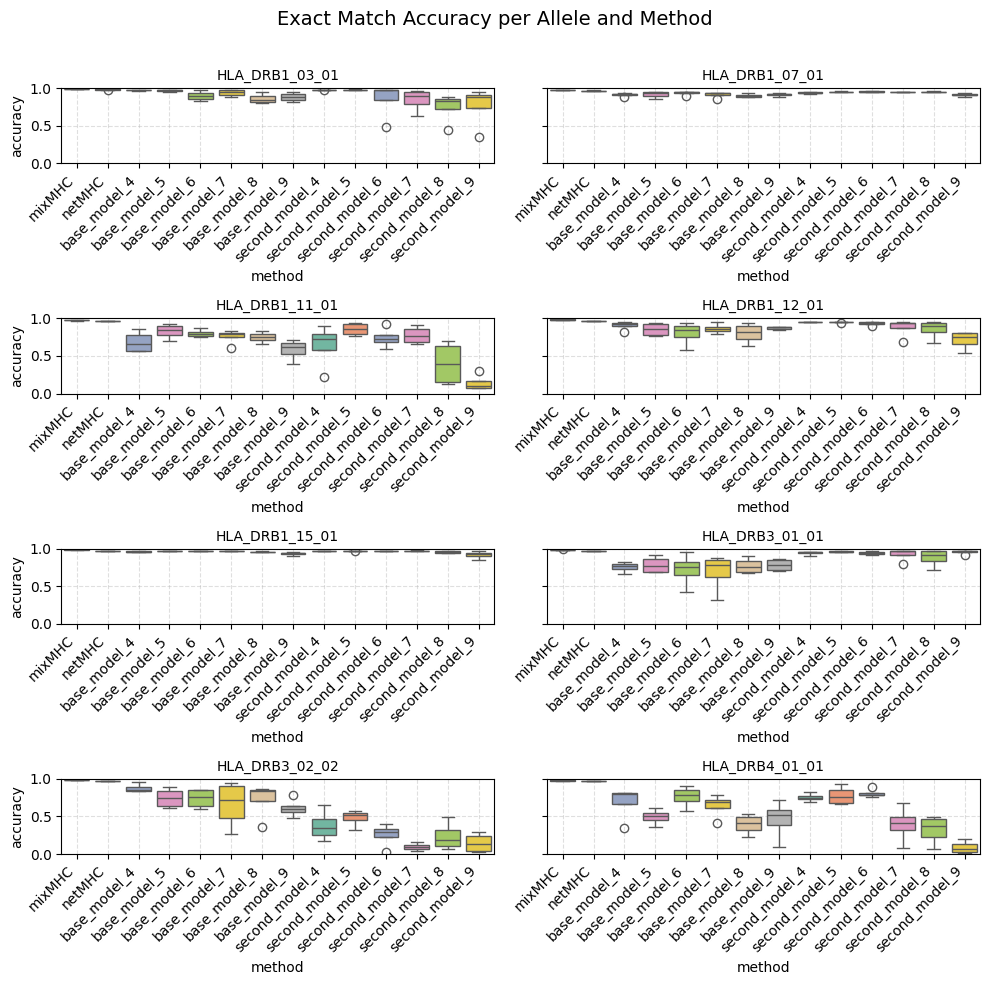

In [59]:
df_exact = results_to_dataframe(results_result)
plot_all_allele_boxplots(df_exact)

In [61]:
# Pivot df_exact so each split becomes a column
pivot_df_exact = df_exact.pivot_table(
    index=['method', 'allele'], 
    columns='split', 
    values='accuracy'
).reset_index()

# Remove column name from columns
pivot_df_exact.columns.name = None

# Rename split columns
pivot_df_exact = pivot_df_exact.rename(columns={i: f'split_{i}' for i in pivot_df_exact.columns if isinstance(i, int)})

# Add mean accuracy
pivot_df_exact['mean_accuracy'] = pivot_df_exact[[col for col in pivot_df_exact.columns if col.startswith('split_')]].mean(axis=1)

# Optional: sort
pivot_df_exact = pivot_df_exact.sort_values(by=['method', 'mean_accuracy'], ascending=[True, False])



C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\230262574.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\230262574.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)  # Adjust the fontsize here
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\230262574.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\230262574.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

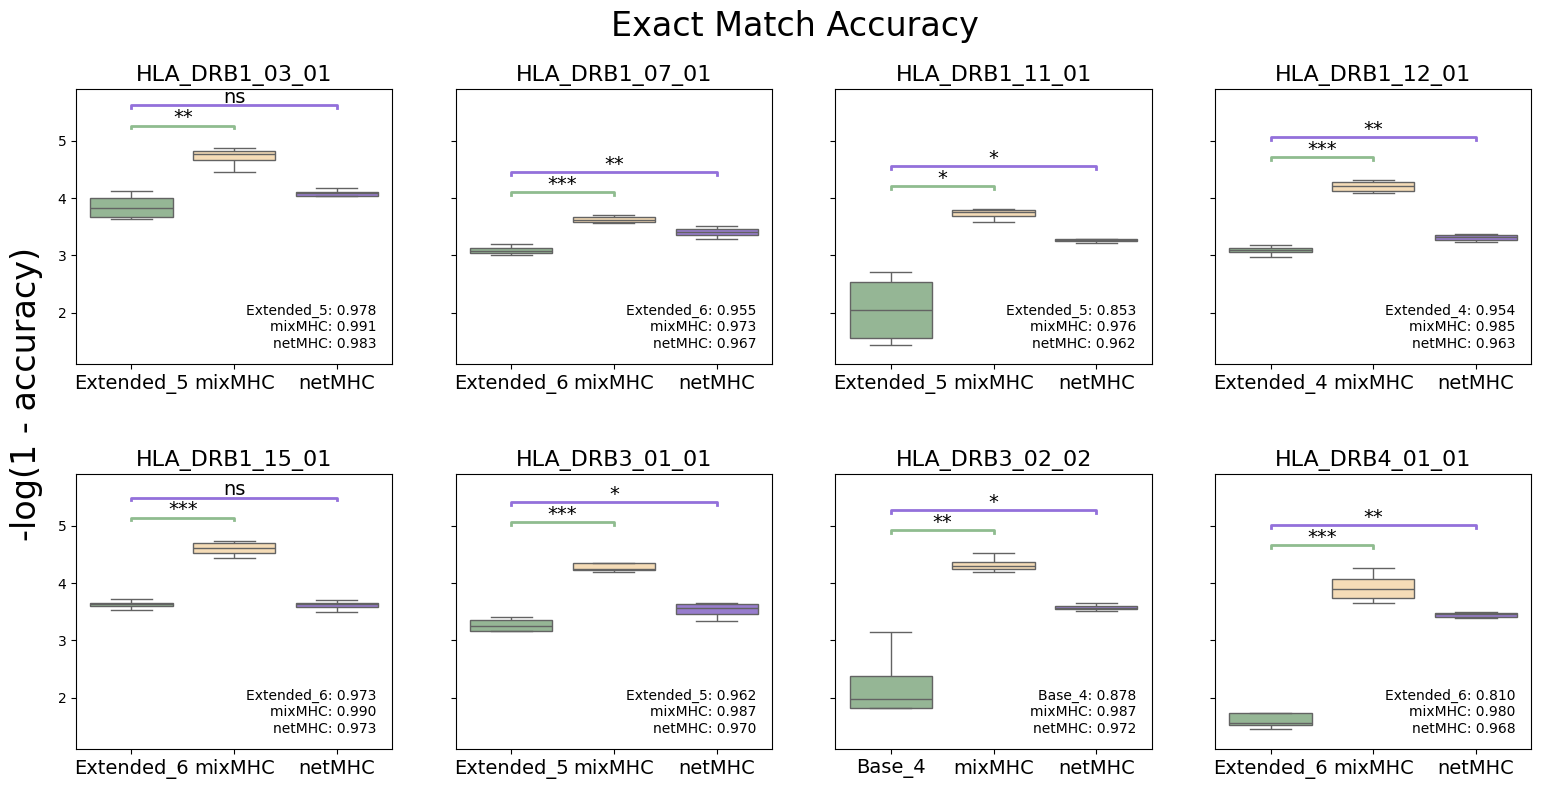

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

# Function to convert p-value to stars
def pval_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

# Custom palette for consistent coloring
palette = ["darkseagreen", "navajowhite", "mediumpurple"]

# Exclude mixMHC and netMHC for best model selection
exclude_methods = ['mixMHC', 'netMHC']
filtered_df = pivot_df_exact[~pivot_df_exact['method'].isin(exclude_methods)]

# Get best model per allele
best_models = (
    filtered_df.loc[filtered_df.groupby('allele')['mean_accuracy'].idxmax()]
    .set_index('allele')
)

# Include mixMHC and netMHC
comparison_models = pivot_df_exact[pivot_df_exact['method'].isin(['mixMHC', 'netMHC'])]

# Prepare layout
alleles = best_models.index.unique()
n_alleles = len(alleles)
n_cols = 4
n_rows = (n_alleles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8), sharey=True)

axes = np.array(axes).reshape((n_rows, n_cols))  # Ensures it's always 2D

for row in range(n_rows):
    for col in range(n_cols):
        axes[row][col].set_ylim(1.1, 5.9)


all_plots_data = []

for idx, allele in enumerate(alleles):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    best_row = best_models.loc[allele]
    best_method = best_row['method']
    
    data = []
    best_scores = best_row[['split_1', 'split_2', 'split_3', 'split_4']].values.astype(float)
    data.extend([(best_method, s) for s in best_scores])
    
    comparisons = {}

    for method in ['mixMHC', 'netMHC']:
        row_match = comparison_models[(comparison_models['allele'] == allele) & (comparison_models['method'] == method)]
        if not row_match.empty:
            scores = row_match.iloc[0][['split_1', 'split_2', 'split_3', 'split_4']].values.astype(float)
            data.extend([(method, s) for s in scores])
            comparisons[method] = scores

    plot_df = pd.DataFrame(data, columns=['Method', 'Accuracy'])

    # Replace best method label with display name
    display_model_name = best_method.replace("second_model", "Extended").replace("base_model", "Base")
    plot_df['Method'] = plot_df['Method'].replace({best_method: display_model_name})

    # Update best_method variable so it's consistent later
    best_method = display_model_name

    plot_df['Log_Accuracy'] = -np.log(1 - plot_df['Accuracy'] + 1e-6)


    #display_model_name = best_method.replace("second_model", "Extended").replace("base_model", "Base")

    all_plots_data.append((ax, plot_df, best_method, comparisons, allele))

# Sort methods consistently for palette mapping
method_order = None  # We'll define it individually per subplot


palette_dict = {
    'mixMHC': "navajowhite",
    'netMHC': "mediumpurple"
}

plot_df
# ... (previous code remains the same until the plotting loop)

for ax, plot_df, best_method, comparisons, allele in all_plots_data:
    display_model_name = best_method.replace("second_model", "Extended").replace("base_model", "Base")
    methods_present = [best_method, 'mixMHC', 'netMHC']
    methods_present = [m for m in methods_present if m in plot_df['Method'].unique()]

    # Dynamically assign color to the best model
    local_palette = {
        display_model_name: "darkseagreen",
        'mixMHC': "navajowhite",
        'netMHC': "mediumpurple"
    }

    sns.boxplot(
        x='Method', y='Log_Accuracy', data=plot_df,
        ax=ax, order=methods_present,
        palette=[local_palette[m] for m in methods_present], showfliers=False 
    )

    ax.set_title(allele, fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)  # Adjust the fontsize here

    # Calculate and display mean accuracy for each method
    mean_accuracies = plot_df.groupby('Method')['Accuracy'].mean()
    text_str = ""
    for method, acc in mean_accuracies.items():
        text_str += f"{method}: {acc:.3f}\n"
    
    # Add text in bottom right corner
    ax.text(0.95, 0.05, text_str.strip(), 
            transform=ax.transAxes, 
            fontsize=10, 
            verticalalignment='bottom', 
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Significance annotations
    methods_ordered = plot_df['Method'].unique().tolist()
    for i, method in enumerate(methods_ordered):
        if method in comparisons:
            pval = ttest_ind(plot_df[plot_df['Method'] == best_method]['Log_Accuracy'],
                             plot_df[plot_df['Method'] == method]['Log_Accuracy'],
                             equal_var=False).pvalue
            stars = pval_to_stars(pval)

            x1 = methods_ordered.index(best_method)
            x2 = methods_ordered.index(method)
            y = plot_df['Log_Accuracy'].max() + 0.35 * i
            h = 0.05

            if method == "mixMHC": color = "darkseagreen"
            elif method == "netMHC": color = "mediumpurple"

            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2, color = color)
            ax.text((x1 + x2) / 2, y + 0.02, stars, ha='center', va='bottom', fontsize=14)

    ax.grid(False)

# ... (rest of the code remains the same)

# Remove unused axes
for i in range(n_alleles, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

fig.text(0.02, 0.5, '-log(1 - accuracy)', ha='center', va='center', rotation='vertical', fontsize=24)


# Main title
plt.tight_layout(rect=[0.03, 0, 0.97, 0.93])
plt.subplots_adjust(hspace=0.4, wspace=0.2)  # Increased vertical spacing

fig.suptitle("Exact Match Accuracy", fontsize=24)
plt.savefig(f"plots//Exact_Match_Accuracy.png", dpi=300)
plt.show()

# B. Shift-Tolerant Positional Match

C:\Users\rpole\AppData\Local\Temp\ipykernel_10792\3560352863.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\rpole\AppData\Local\Temp\ipykernel_10792\3560352863.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\rpole\AppData\Local\Temp\ipykernel_10792\3560352863.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\rpole\AppData\Local\Temp\ipykernel_10792\3560352863.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; 

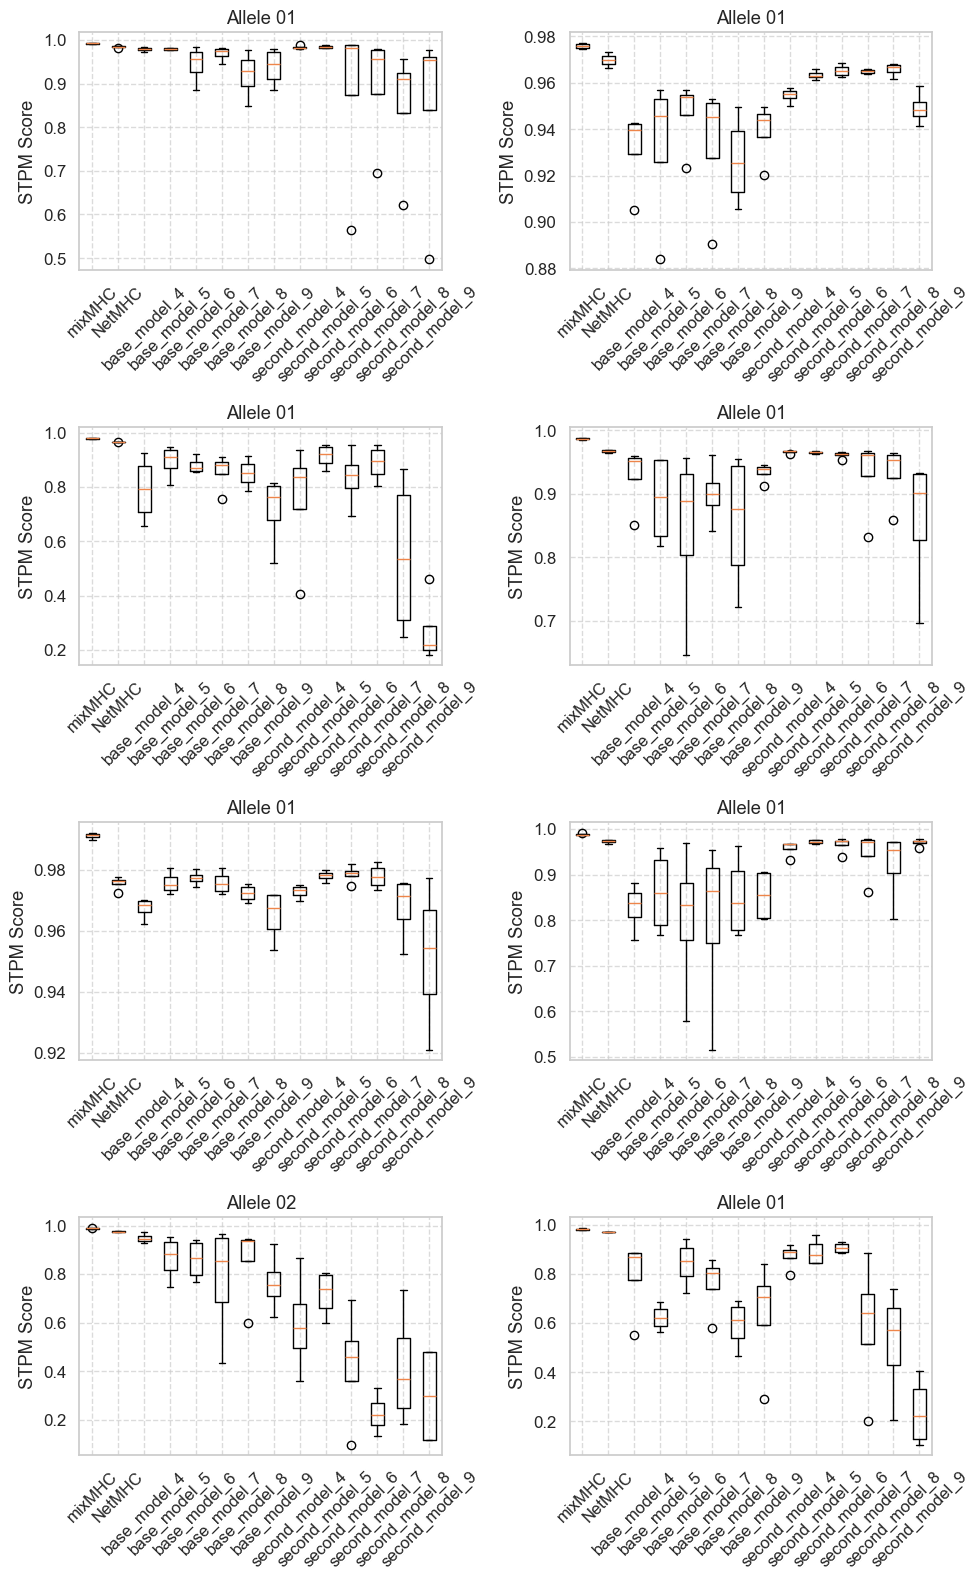

In [334]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict

def shift_tolerant_positional_match(ref_core, pred_core):
    """Calculates the Shift-Tolerant Positional Match between two cores."""
    max_match = 0
    len_ref = len(ref_core)
    len_pred = len(pred_core)

    for shift in range(-abs(len_pred - len_ref), abs(len_pred - len_ref) + 1):
        match_count = 0
        for i in range(len_ref):
            j = i + shift
            if 0 <= j < len_pred:
                if ref_core[i] == pred_core[j]:
                    match_count += 1
        max_match = max(max_match, match_count)

    return max_match / len_ref

def compare_cores_with_reference(allele_splits, mixMHC_dict, netmhc_core_sorted, experiments_dict):
    results = defaultdict(lambda: defaultdict(dict))

    for allele, splits in allele_splits.items():
        for split, peptides in splits.items():
            for peptide, ref_core in peptides.items():
                if len(peptide) > 18:
                    continue

                # Process mixMHC
                pred_core = mixMHC_dict.get(allele, {}).get(int(split), {}).get(peptide)
                if pred_core:
                    score = shift_tolerant_positional_match(ref_core, pred_core)
                    results[allele]["mixMHC"].setdefault(split, []).append(score)

                # Process NetMHC
                if allele in netmhc_core_sorted:
                    str_split = str(split)
                    if str_split in netmhc_core_sorted[allele]:
                        pred_core = netmhc_core_sorted[allele][str_split].get(peptide)
                        if pred_core:
                            score = shift_tolerant_positional_match(ref_core, pred_core)
                            results[allele]["NetMHC"].setdefault(split, []).append(score)

                # Process experiments
                for exp_name, exp_data in experiments_dict.items():
                    pred_core = exp_data.get(allele, {}).get(str(split), {}).get(peptide)
                    if pred_core:
                        score = shift_tolerant_positional_match(ref_core, pred_core)
                        results[allele][exp_name].setdefault(split, []).append(score)

    # Calculate average scores
    for allele in results:
        for source in results[allele]:
            for split in results[allele][source]:
                scores = results[allele][source][split]
                results[allele][source][split] = np.mean(scores) if scores else None

    return results

def plot_combined_boxplots(results):
    """Create a single figure with subplots for each allele"""
    n_alleles = len(results)
    n_cols = 2  # Maximum 3 columns
    n_rows = 4
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_alleles == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Flatten axes for easy iteration
    axes_flat = axes.flatten()
    
    for idx, (allele, sources) in enumerate(results.items()):
        ax = axes_flat[idx]
        data = []
        labels = []

        # Collect data for each source
        for source, source_data in sources.items():
            split_scores = [score for score in source_data.values() if score is not None]
            if split_scores:
                data.append(split_scores)
                labels.append(source)

        # Create boxplot
        ax.boxplot(data, labels=labels)
        ax.set_title(f"Allele {allele.split('_')[-1]}")
        ax.set_ylabel("STPM Score")
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, linestyle='--', alpha=0.7)

    # Hide empty subplots
    for j in range(len(results), len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
results_Shift = compare_cores_with_reference(allele_splits, mixmhc_cores, netmhc_core_sorted, all_consensus)
plot_combined_boxplots(results_Shift)

In [433]:
import pandas as pd

# Flatten the nested dictionary into a list of records
records = []
for allele, methods in results_Shift.items():
    for method, splits in methods.items():
        for split, accuracy in splits.items():
            records.append({
                'allele': allele,
                'method': method,
                'split': split,
                'accuracy': accuracy
            })

# Create DataFrame
df_shift = pd.DataFrame(records)

# Pivot so each split is a column
pivot_df_shifts = df_shift.pivot_table(
    index=['method', 'allele'], 
    columns='split', 
    values='accuracy'
).reset_index()

# Optionally rename the split columns (e.g., 1 -> split_1)
pivot_df_shifts.columns.name = None
pivot_df_shifts = pivot_df_shifts.rename(columns={i: f'split_{i}' for i in range(1, 5)})

# Add mean accuracy column
pivot_df_shifts['mean_accuracy'] = pivot_df_shifts[[f'split_{i}' for i in range(1, 5)]].mean(axis=1)

# Optional: sort
pivot_df_shifts = pivot_df_shifts.sort_values(by=['method', 'mean_accuracy'], ascending=[True, False])


In [434]:
pivot_df_shifts

method          allele   split_1   split_2   split_3   split_4  \
0            NetMHC  HLA_DRB1_03_01  0.981333  0.984779  0.986381  0.984794   
4            NetMHC  HLA_DRB1_15_01  0.972401  0.976216  0.976394  0.977438   
6            NetMHC  HLA_DRB3_02_02  0.974045  0.975702  0.976146  0.973149   
5            NetMHC  HLA_DRB3_01_01  0.972858  0.975756  0.968102  0.976620   
7            NetMHC  HLA_DRB4_01_01  0.971897  0.972633  0.970486  0.968927   
..              ...             ...       ...       ...       ...       ...   
107  second_model_9  HLA_DRB1_12_01  0.931351  0.933573  0.696936  0.871098   
104  second_model_9  HLA_DRB1_03_01  0.952984  0.976285  0.496960  0.954883   
110  second_model_9  HLA_DRB3_02_02  0.479090  0.117775  0.119416  0.480678   
106  second_model_9  HLA_DRB1_11_01  0.182944  0.459305  0.230036  0.206335   
111  second_model_9  HLA_DRB4_01_01  0.403201  0.137110  0.105101  0.306295   

     mean_accuracy  
0         0.984322  
4         0.975612  
6         0.974761  
5         0.973334  
7         0.970986  
..             ...  
107       0.858239  
104       0.845278  
110       0.299240  
106       0.269655  
111       0.237927  

[112 rows x 7 columns]

C:\Users\rpole\AppData\Local\Temp\ipykernel_10792\232115372.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\rpole\AppData\Local\Temp\ipykernel_10792\232115372.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
C:\Users\rpole\AppData\Local\Temp\ipykernel_10792\232115372.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\rpole\AppData\Local\Temp\ipykernel_10792\232115372.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels

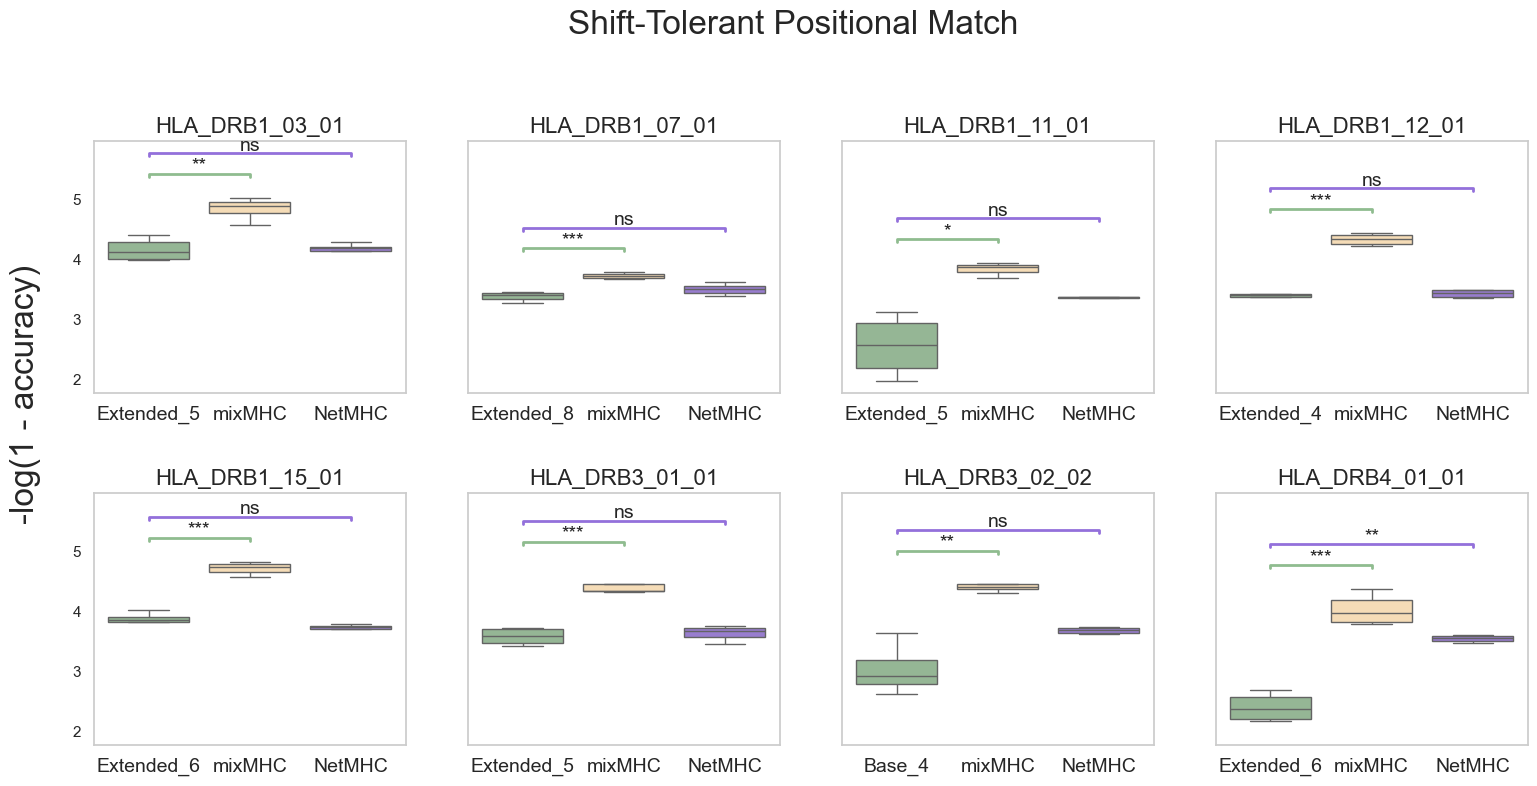

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

# Function to convert p-value to stars
def pval_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

# Custom palette for consistent coloring
palette = ["darkseagreen", "navajowhite", "mediumpurple"]

# Exclude mixMHC and netMHC for best model selection
exclude_methods = ['mixMHC', 'NetMHC']
filtered_df = pivot_df_shifts[~pivot_df_shifts['method'].isin(exclude_methods)]

# Get best model per allele
best_models = (
    filtered_df.loc[filtered_df.groupby('allele')['mean_accuracy'].idxmax()]
    .set_index('allele')
)

# Include mixMHC and netMHC
comparison_models = pivot_df_shifts[pivot_df_shifts['method'].isin(['mixMHC', 'NetMHC'])]

# Prepare layout
alleles = best_models.index.unique()
n_alleles = len(alleles)
n_cols = 4
n_rows = (n_alleles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8), sharey=True)

all_plots_data = []

for idx, allele in enumerate(alleles):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    best_row = best_models.loc[allele]
    best_method = best_row['method']
    
    data = []
    best_scores = best_row[['split_1', 'split_2', 'split_3', 'split_4']].values.astype(float)
    data.extend([(best_method, s) for s in best_scores])
    
    comparisons = {}

    for method in ['mixMHC', 'NetMHC']:
        row_match = comparison_models[(comparison_models['allele'] == allele) & (comparison_models['method'] == method)]
        if not row_match.empty:
            scores = row_match.iloc[0][['split_1', 'split_2', 'split_3', 'split_4']].values.astype(float)
            data.extend([(method, s) for s in scores])
            comparisons[method] = scores

    plot_df = pd.DataFrame(data, columns=['Method', 'Accuracy'])

    # Replace best method label with display name
    display_model_name = best_method.replace("second_model", "Extended").replace("base_model", "Base")
    plot_df['Method'] = plot_df['Method'].replace({best_method: display_model_name})

    # Update best_method variable so it's consistent later
    best_method = display_model_name

    plot_df['Log_Accuracy'] = -np.log(1 - plot_df['Accuracy'] + 1e-6)


    all_plots_data.append((ax, plot_df, best_method, comparisons, allele))

# Sort methods consistently for palette mapping
method_order = None  # We'll define it individually per subplot


palette_dict = {
    'mixMHC': "navajowhite",
    'NetMHC': "mediumpurple"
}


for ax, plot_df, best_method, comparisons, allele in all_plots_data:

    display_model_name = best_method.replace("second_model", "Extended").replace("base_model", "Base")
    methods_present = [best_method, 'mixMHC', 'NetMHC']
    methods_present = [m for m in methods_present if m in plot_df['Method'].unique()]

    # Dynamically assign color to the best model
    local_palette = {
        display_model_name: "darkseagreen",
        'mixMHC': "navajowhite",
        'NetMHC': "mediumpurple"
    }

    sns.boxplot(
        x='Method', y='Log_Accuracy', data=plot_df,
        ax=ax, order=methods_present,
        palette=[local_palette[m] for m in methods_present], showfliers=False 
    )

    ax.set_title(allele, fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


    # Significance annotations
    methods_ordered = plot_df['Method'].unique().tolist()
    for i, method in enumerate(methods_ordered):
        if method in comparisons:
            pval = ttest_ind(plot_df[plot_df['Method'] == best_method]['Log_Accuracy'],
                             plot_df[plot_df['Method'] == method]['Log_Accuracy'],
                             equal_var=False).pvalue


            stars = pval_to_stars(pval)

            x1 = methods_ordered.index(best_method)
            x2 = methods_ordered.index(method)
            y = plot_df['Log_Accuracy'].max() + 0.35 * i
            h = 0.05
            if method == "mixMHC": color = "darkseagreen"
            elif method == "NetMHC": color = "mediumpurple"

            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2, color = color)
            ax.text((x1 + x2) / 2, y + 0.02, stars, ha='center', va='bottom', fontsize=14)

    ax.grid(False)


# Remove unused axes
for i in range(n_alleles, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

# Shared y-label
fig.text(0.02, 0.5, '-log(1 - accuracy)', ha='center', va='center', rotation='vertical', fontsize=24)


# Main title
fig.suptitle("Shift-Tolerant Positional Match", fontsize=24)
plt.tight_layout(rect=[0.03, 0, 0.97, 0.93])
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.savefig(f"plots//Shift-Tolerant_Positional_Match.png", dpi=300)
plt.show()




# C. Amino Acid Overlap (Jaccard Index)

In [304]:
from collections import defaultdict
from sklearn.metrics import f1_score, jaccard_score
import numpy as np

def aa_overlap_metrics(reference_core: str, predicted_core: str):
    """
    Computes F1-score and Jaccard Index at amino acid level.
    """
    ref_set = set(reference_core)
    pred_set = set(predicted_core)
    
    intersection = len(ref_set & pred_set)
    union = len(ref_set | pred_set)
    
    precision = intersection / len(pred_set) if pred_set else 0
    recall = intersection / len(ref_set) if ref_set else 0

    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    jaccard = intersection / union if union else 0

    return f1, jaccard


def compare_cores_to_reference(
    allele_splits: dict,
    experiments: dict,
    mixmhc: dict,
    netmhc: dict
):
    """
    Compares all predicted core sets (from mixMHC, NetMHC, experiments) to reference cores.
    Returns per-allele F1 and Jaccard scores.
    """
    results = defaultdict(lambda: defaultdict(dict))  # results[method][allele] = {'f1': avg, 'jaccard': avg}

    all_methods = {
        **experiments,  # experiments dict: {experiment: {allele: {split: {peptide: core}}}}
        'mixMHC': mixmhc,
        'NetMHC': netmhc
    }

    for method, method_data in all_methods.items():
        for allele in allele_splits:
            f1_scores = []
            jaccard_scores = []

            for split, peptides in allele_splits[allele].items():
                split_str = str(split)  # Normalize split keys as strings

                ref_peptides = peptides
                pred_peptides = method_data.get(allele, {}).get(split_str, {})

                for peptide, ref_core in ref_peptides.items():
                    pred_core = pred_peptides.get(peptide)
                    if pred_core:
                        f1, jaccard = aa_overlap_metrics(ref_core, pred_core)
                        f1_scores.append(f1)
                        jaccard_scores.append(jaccard)

            if f1_scores:
                results[method][allele]['f1'] = np.mean(f1_scores)
                results[method][allele]['jaccard'] = np.mean(jaccard_scores)
            else:
                results[method][allele]['f1'] = None
                results[method][allele]['jaccard'] = None

    return results


In [305]:
results = compare_cores_to_reference(
    allele_splits=allele_splits,
    experiments=all_consensus,  # e.g., {'base_model_1': {...}, ...}
    mixmhc=mixmhc_cores,
    netmhc=netmhc_core_sorted
)

# Print results nicely
import pprint
pprint.pprint(results)


defaultdict(<function compare_cores_to_reference.<locals>.<lambda> at 0x000001F5AB0F8790>,
            {'NetMHC': defaultdict(<class 'dict'>,
                                   {'HLA_DRB1_03_01': {'f1': 0.9950267901804107,
                                                       'jaccard': 0.992427380386698},
                                    'HLA_DRB1_07_01': {'f1': 0.9892962493437344,
                                                       'jaccard': 0.9835310960518825},
                                    'HLA_DRB1_11_01': {'f1': 0.9880409448495904,
                                                       'jaccard': 0.9812603322654899},
                                    'HLA_DRB1_12_01': {'f1': 0.9882143383764154,
                                                       'jaccard': 0.9820382195522862},
                                    'HLA_DRB1_15_01': {'f1': 0.9927240555043214,
                                                       'jaccard': 0.9888505571033632},
                   

In [306]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import pandas as pd


def aa_overlap_metrics(reference_core: str, predicted_core: str):
    ref_set = set(reference_core)
    pred_set = set(predicted_core)
    
    intersection = len(ref_set & pred_set)
    union = len(ref_set | pred_set)
    
    precision = intersection / len(pred_set) if pred_set else 0
    recall = intersection / len(ref_set) if ref_set else 0

    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    jaccard = intersection / union if union else 0

    return f1, jaccard


def collect_scores_per_split(
    allele_splits: dict,
    experiments: dict,
    mixmhc: dict,
    netmhc: dict
):
    """
    Collect F1 and Jaccard scores for each peptide across splits, tools, and alleles.
    Returns a long-form DataFrame for boxplot visualization.
    """
    rows = []

    all_methods = {
        **experiments,
        'mixMHC': mixmhc,
        'NetMHC': netmhc
    }

    for method, method_data in all_methods.items():
        for allele in allele_splits:
            if allele not in method_data:
                continue
            for split, ref_peptides in allele_splits[allele].items():
                split_str = str(split)
                pred_peptides = method_data.get(allele, {}).get(split_str, {})

                for peptide, ref_core in ref_peptides.items():
                    pred_core = pred_peptides.get(peptide)
                    if pred_core:
                        f1, jaccard = aa_overlap_metrics(ref_core, pred_core)
                        rows.append({
                            'allele': allele,
                            'split': split,
                            'method': method,
                            'f1': f1,
                            'jaccard': jaccard
                        })

    return pd.DataFrame(rows)


def plot_overlap_boxplots(score_df):
    """
    Create boxplots (per allele) showing F1 and Jaccard overlap per method.
    """
    for metric in ['f1', 'jaccard']:
        for allele in score_df['allele'].unique():
            plt.figure(figsize=(10, 6))
            subset = score_df[score_df['allele'] == allele]
            sns.boxplot(data=subset, x='method', y=metric)
            sns.stripplot(data=subset, x='method', y=metric, color='black', size=3, jitter=True, alpha=0.4)
            plt.title(f"{metric.upper()} Score per Method for {allele}")
            plt.ylabel(metric.upper())
            plt.xlabel("Method")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


In [307]:
score_df = collect_scores_per_split(
    allele_splits=allele_splits,
    experiments=all_consensus,  # e.g., {'base_model_1': {...}, ...}
    mixmhc=mixmhc_cores,
    netmhc=netmhc_core_sorted
)

defaultdict(<function compare_cores_to_reference.<locals>.<lambda> at 0x000001F5AB0F8790>,
            {'NetMHC': defaultdict(<class 'dict'>,
                                   {'HLA_DRB1_03_01': {'f1': 0.9950267901804107,
                                                       'jaccard': 0.992427380386698},
                                    'HLA_DRB1_07_01': {'f1': 0.9892962493437344,
                                                       'jaccard': 0.9835310960518825},
                                    'HLA_DRB1_11_01': {'f1': 0.9880409448495904,
                                                       'jaccard': 0.9812603322654899},
                                    'HLA_DRB1_12_01': {'f1': 0.9882143383764154,
                                                       'jaccard': 0.9820382195522862},
                                    'HLA_DRB1_15_01': {'f1': 0.9927240555043214,
                                                       'jaccard': 0.9888505571033632},
                   


=== Comparison Summary ===
Total comparisons: 448
Unique alleles: 8
Methods compared: MixMHC, NetMHC, base_model_4, base_model_5, base_model_6, base_model_7, base_model_8, base_model_9, second_model_4, second_model_5, second_model_6, second_model_7, second_model_8, second_model_9

Average Jaccard indices by method:
Method
MixMHC            0.996
NetMHC            0.993
second_model_5    0.973
base_model_6      0.965
base_model_4      0.964
second_model_6    0.964
second_model_4    0.964
base_model_7      0.960
base_model_5      0.959
base_model_8      0.951
base_model_9      0.951
second_model_7    0.949
second_model_8    0.937
second_model_9    0.923
Name: Jaccard, dtype: float64

Results saved to 'core_comparison_results.csv'


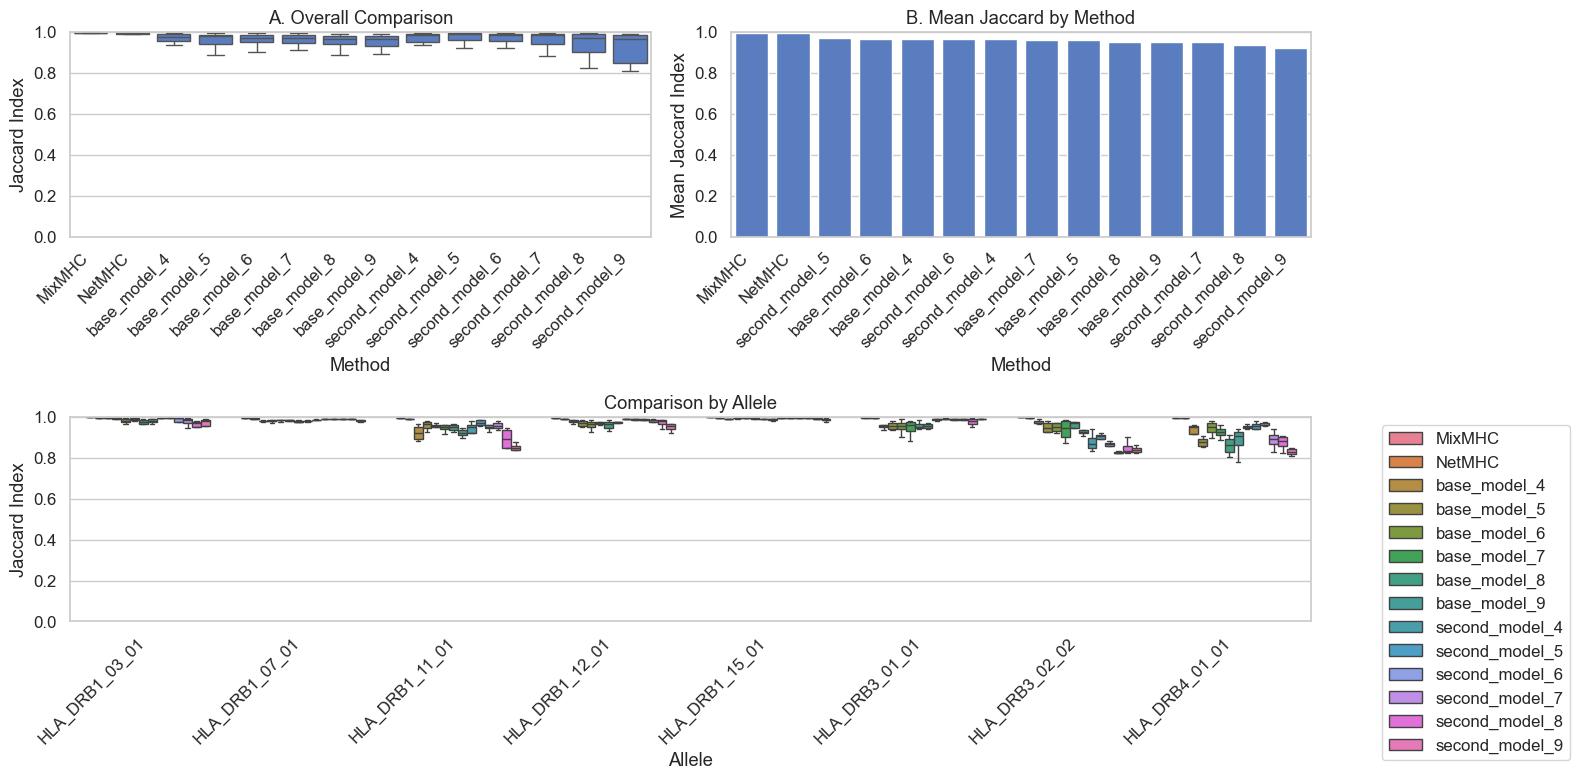

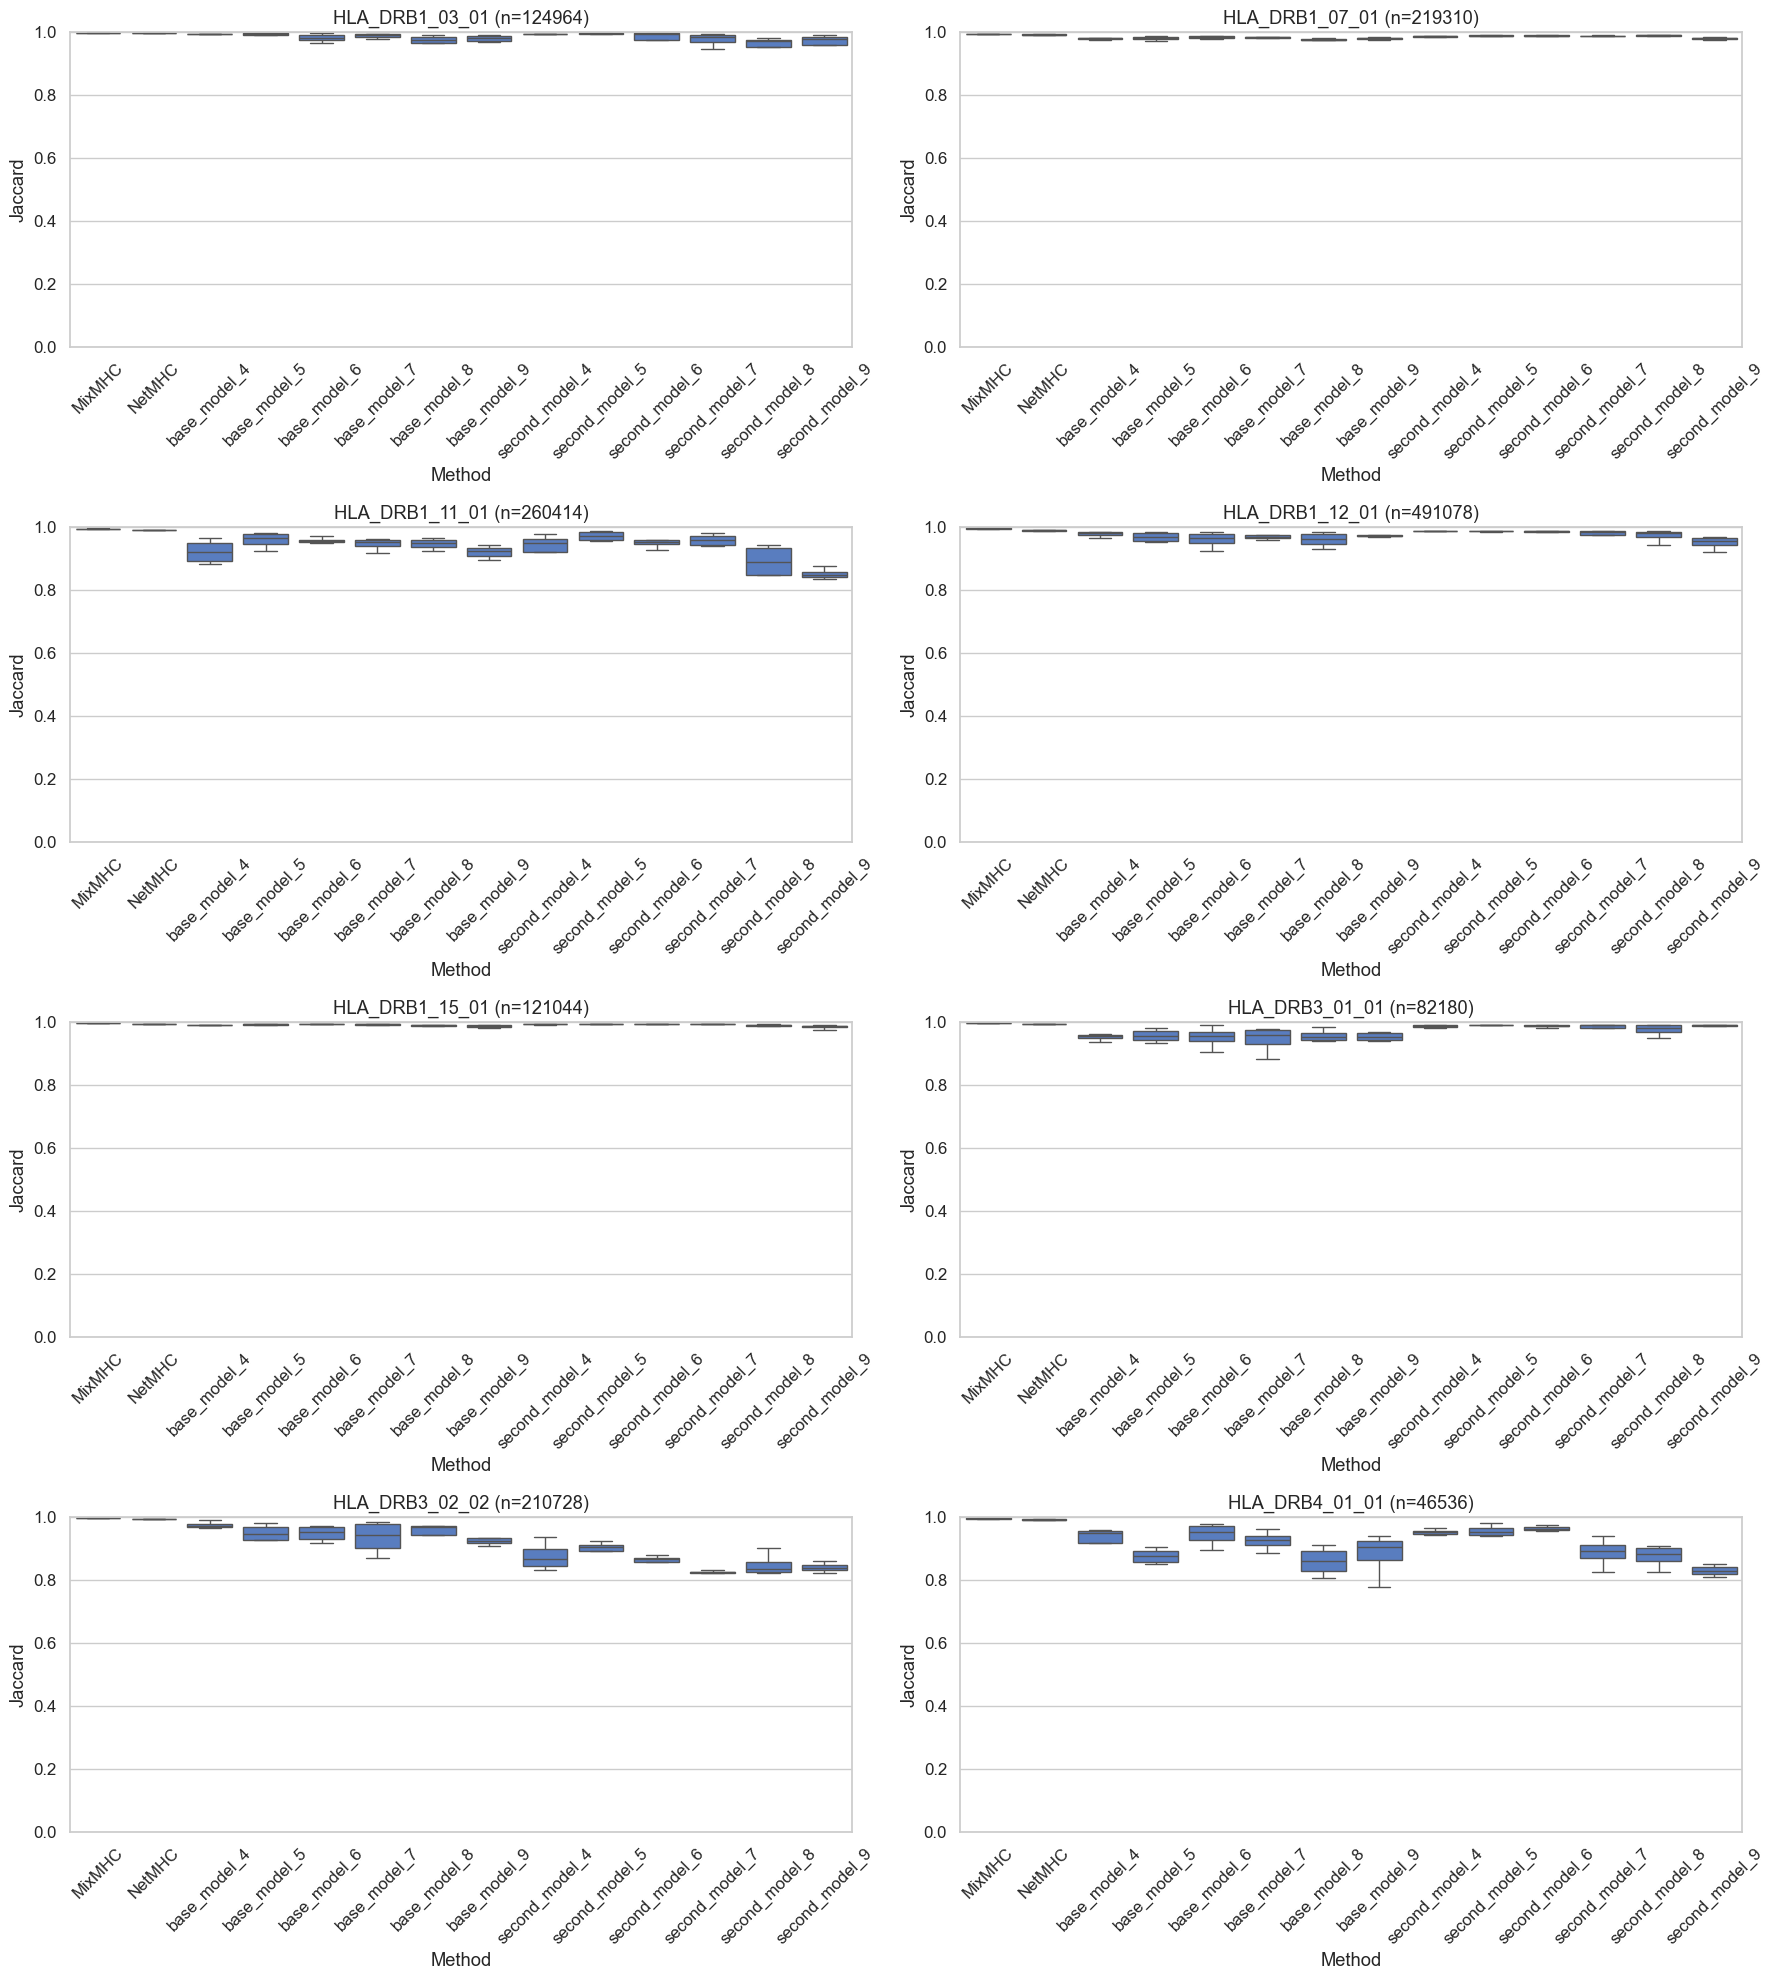

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, OrderedDict

def calculate_jaccard(core1, core2):
    """Calculate Jaccard Index between two core sequences with validation"""
    if not isinstance(core1, str) or not isinstance(core2, str):
        return np.nan
    if len(core1) == 0 or len(core2) == 0:
        return np.nan
    set1 = set(core1)
    set2 = set(core2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def compare_cores(reference_dict, comparison_dicts, max_peptide_length=18):
    """
    Compare core predictions from multiple sources against reference
    Returns a DataFrame with Jaccard indices for each allele, split, and method
    """
    results = []
    
    for allele in reference_dict:
        if allele not in reference_dict:
            continue
            
        for split in reference_dict[allele]:
            ref_cores = reference_dict[allele][split]
            
            for method_name, method_dict in comparison_dicts.items():
                try:
                    # Get comparison cores based on different dict structures
                    if isinstance(method_dict, (dict, defaultdict)):
                        if allele in method_dict:
                            split_data = method_dict[allele]
                            if split in split_data:
                                comp_cores = split_data[split]
                            elif str(split) in split_data:
                                comp_cores = split_data[str(split)]
                            else:
                                continue
                        else:
                            continue
                    elif isinstance(method_dict, OrderedDict):
                        if allele in method_dict:
                            if str(split) in method_dict[allele]:
                                comp_cores = method_dict[allele][str(split)]
                            else:
                                continue
                        else:
                            continue
                    else:
                        continue
                except (KeyError, TypeError, AttributeError) as e:
                    print(f"Skipping {method_name} for {allele} split {split}: {str(e)}")
                    continue
                
                # Calculate Jaccard for each peptide-core pair
                jaccards = []
                matched_peptides = 0
                for peptide, ref_core in ref_cores.items():
                    # Skip long peptides
                    if len(peptide) > max_peptide_length:
                        continue
                        
                    if peptide in comp_cores:
                        comp_core = comp_cores[peptide]
                        jaccard = calculate_jaccard(ref_core, comp_core)
                        if not np.isnan(jaccard):
                            jaccards.append(jaccard)
                            matched_peptides += 1
                
                if jaccards:
                    mean_jaccard = np.mean(jaccards)
                    results.append({
                        'Allele': allele,
                        'Split': split,
                        'Method': method_name,
                        'Jaccard': mean_jaccard,
                        'Matched Peptides': matched_peptides,
                        'Median Jaccard': np.median(jaccards),
                        'Min Jaccard': np.min(jaccards),
                        'Max Jaccard': np.max(jaccards)
                    })
    
    return pd.DataFrame(results)

def plot_jaccard_comparison(results_df):
    """Create plots comparing Jaccard indices across methods and alleles"""
    if results_df.empty:
        print("No data to plot")
        return
    
    # Set plotting style
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)
    plt.figure(figsize=(16, 8))
    
    # Plot 1: Overall comparison
    plt.subplot(2, 2, 1)
    sns.boxplot(data=results_df, x='Method', y='Jaccard', showfliers=False)
    plt.title('A. Overall Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.ylabel('Jaccard Index')
    
    # Plot 2: Best performing methods
    plt.subplot(2, 2, 2)
    method_means = results_df.groupby('Method')['Jaccard'].mean().sort_values(ascending=False)
    sns.barplot(x=method_means.index, y=method_means.values, order=method_means.index)
    plt.title('B. Mean Jaccard by Method')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.ylabel('Mean Jaccard Index')
    
    # Plot 3: By allele
    plt.subplot(2, 1, 2)
    sns.boxplot(data=results_df, x='Allele', y='Jaccard', hue='Method', showfliers=False)
    plt.title('Comparison by Allele')
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)
    plt.ylabel('Jaccard Index')
    
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Individual allele subplots
    alleles = results_df['Allele'].unique()
    n_cols = 2
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    
    if len(alleles) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, allele in enumerate(alleles):
        ax = axes[i]
        allele_data = results_df[results_df['Allele'] == allele]
        sns.boxplot(data=allele_data, x='Method', y='Jaccard', ax=ax, showfliers=False)
        ax.set_title(f'{allele} (n={allele_data["Matched Peptides"].sum()})')
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Prepare your data
comparison_dicts = {
    'MixMHC': mixmhc_cores,
    'NetMHC': netmhc_core_sorted,
    **{exp_name: exp_data for exp_name, exp_data in all_consensus.items()}
}

# Compare all methods against reference (filtering peptides >18aa)
results_df = compare_cores(allele_splits, comparison_dicts, max_peptide_length=18)

# Display summary statistics
print("\n=== Comparison Summary ===")
print(f"Total comparisons: {len(results_df)}")
print(f"Unique alleles: {results_df['Allele'].nunique()}")
print(f"Methods compared: {', '.join(results_df['Method'].unique())}")
print("\nAverage Jaccard indices by method:")
print(results_df.groupby('Method')['Jaccard'].mean().sort_values(ascending=False).round(3))

# Save results
results_df.to_csv('core_comparison_results.csv', index=False)
print("\nResults saved to 'core_comparison_results.csv'")

# Generate plots
plot_jaccard_comparison(results_df)

In [345]:
results_df

Allele  Split          Method   Jaccard  Matched Peptides  \
0    HLA_DRB1_03_01      1          MixMHC  0.996689              2238   
1    HLA_DRB1_03_01      1          NetMHC  0.994897              2238   
2    HLA_DRB1_03_01      1    base_model_4  0.991392              2238   
3    HLA_DRB1_03_01      1    base_model_5  0.991832              2238   
4    HLA_DRB1_03_01      1    base_model_6  0.976996              2238   
..              ...    ...             ...       ...               ...   
443  HLA_DRB4_01_01      4  second_model_5  0.940176               826   
444  HLA_DRB4_01_01      4  second_model_6  0.959064               826   
445  HLA_DRB4_01_01      4  second_model_7  0.826634               826   
446  HLA_DRB4_01_01      4  second_model_8  0.907851               826   
447  HLA_DRB4_01_01      4  second_model_9  0.808867               826   

     Median Jaccard  Min Jaccard  Max Jaccard  
0          1.000000     0.444444          1.0  
1          1.000000     0.400000          1.0  
2          1.000000     0.250000          1.0  
3          1.000000     0.250000          1.0  
4          1.000000     0.125000          1.0  
..              ...          ...          ...  
443        1.000000     0.285714          1.0  
444        1.000000     0.250000          1.0  
445        0.857143     0.142857          1.0  
446        1.000000     0.142857          1.0  
447        0.857143     0.250000          1.0  

[448 rows x 8 columns]

In [66]:
import pandas as pd

# Pivot to get each split as a column
pivot_jaccard = results_df.pivot_table(
    index=['Method', 'Allele'],
    columns='Split',
    values='Jaccard'
).reset_index()

# Remove column name from columns
pivot_jaccard.columns.name = None

# Rename split columns
pivot_jaccard = pivot_jaccard.rename(columns={i: f'split_{i}' for i in pivot_jaccard.columns if isinstance(i, int)})

# Add mean_jaccard column
pivot_jaccard['mean_jaccard'] = pivot_jaccard[[col for col in pivot_jaccard.columns if col.startswith('split_')]].mean(axis=1)

# Optional: sort by method and mean_jaccard
pivot_jaccard = pivot_jaccard.sort_values(by=['Method', 'mean_jaccard'], ascending=[True, False])


C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\672003458.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\672003458.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\672003458.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\rpole\AppData\Local\Temp\ipykernel_10268\672003458.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(a

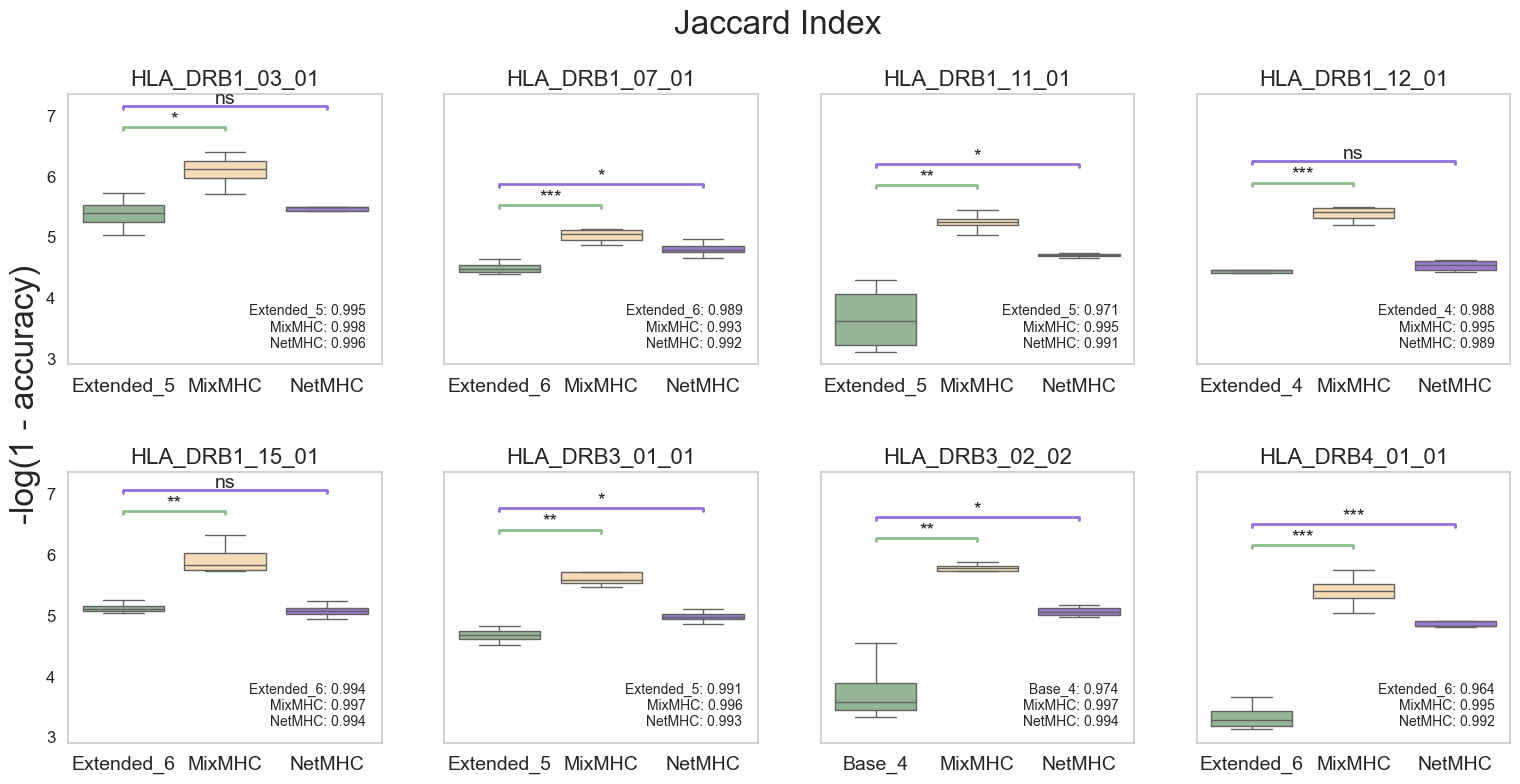

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

# Function to convert p-value to stars
def pval_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

# Custom palette for consistent coloring
palette = ["darkseagreen", "navajowhite", "mediumpurple"]

# Exclude mixMHC and netMHC for best model selection
exclude_methods = ['MixMHC', 'NetMHC']
filtered_df = pivot_jaccard[~pivot_jaccard['Method'].isin(exclude_methods)]

# Get best model per allele
best_models = (
    filtered_df.loc[filtered_df.groupby('Allele')['mean_jaccard'].idxmax()]
    .set_index('Allele')
)

# Include mixMHC and netMHC
comparison_models = pivot_jaccard[pivot_jaccard['Method'].isin(['MixMHC', 'NetMHC'])]

# Prepare layout
alleles = best_models.index.unique()
n_alleles = len(alleles)
n_cols = 4
n_rows = (n_alleles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8), sharey=True)

all_plots_data = []

for idx, allele in enumerate(alleles):
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    best_row = best_models.loc[allele]
    best_method = best_row['Method']
    
    data = []
    best_scores = best_row[['split_1', 'split_2', 'split_3', 'split_4']].values.astype(float)
    data.extend([(best_method, s) for s in best_scores])
    
    comparisons = {}

    for method in ['MixMHC', 'NetMHC']:
        row_match = comparison_models[(comparison_models['Allele'] == allele) & (comparison_models['Method'] == method)]
        if not row_match.empty:
            scores = row_match.iloc[0][['split_1', 'split_2', 'split_3', 'split_4']].values.astype(float)
            data.extend([(method, s) for s in scores])
            comparisons[method] = scores

    plot_df = pd.DataFrame(data, columns=['Method', 'Accuracy'])

    # Replace best method label with display name
    display_model_name = best_method.replace("second_model", "Extended").replace("base_model", "Base")
    plot_df['Method'] = plot_df['Method'].replace({best_method: display_model_name})

    # Update best_method variable so it's consistent later
    best_method = display_model_name

    plot_df['Log_Accuracy'] = -np.log(1 - plot_df['Accuracy'] + 1e-6)


    all_plots_data.append((ax, plot_df, best_method, comparisons, allele))

# Sort methods consistently for palette mapping
method_order = None  # We'll define it individually per subplot


palette_dict = {
    'MixMHC': "navajowhite",
    'NetMHC': "mediumpurple"
}

for ax, plot_df, best_method, comparisons, allele in all_plots_data:
    display_model_name = best_method.replace("second_model", "Extended").replace("base_model", "Base")
    methods_present = [best_method, 'MixMHC', 'NetMHC']
    methods_present = [m for m in methods_present if m in plot_df['Method'].unique()]

    # Dynamically assign color to the best model
    local_palette = {
        display_model_name: "darkseagreen",
        'MixMHC': "navajowhite",
        'NetMHC': "mediumpurple"
    }

    sns.boxplot(
        x='Method', y='Log_Accuracy', data=plot_df,
        ax=ax, order=methods_present,
        palette=[local_palette[m] for m in methods_present], showfliers=False
    )

    ax.set_title(allele, fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

    # Get mean values for all methods
    mean_values = []
    
    # Best model mean
    best_mean_jaccard = best_models.loc[allele, 'mean_jaccard']
    mean_values.append(f"{display_model_name}: {best_mean_jaccard:.3f}")
    
    # MixMHC mean if present
    if 'MixMHC' in plot_df['Method'].unique():
        mixmhc_mean = plot_df[plot_df['Method'] == 'MixMHC']['Accuracy'].mean()
        mean_values.append(f"MixMHC: {mixmhc_mean:.3f}")
    
    # NetMHC mean if present
    if 'NetMHC' in plot_df['Method'].unique():
        netmhc_mean = plot_df[plot_df['Method'] == 'NetMHC']['Accuracy'].mean()
        mean_values.append(f"NetMHC: {netmhc_mean:.3f}")
    
    # Create the text to display
    mean_text = "\n".join(mean_values)
    
    # Add mean values text in the bottom right corner
    ax.text(0.95, 0.05, mean_text, 
            transform=ax.transAxes, ha='right', va='bottom',
            fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))



    # Significance annotations
    methods_ordered = plot_df['Method'].unique().tolist()
    for i, method in enumerate(methods_ordered):
        if method in comparisons:
            pval = ttest_ind(plot_df[plot_df['Method'] == best_method]['Log_Accuracy'],
                             plot_df[plot_df['Method'] == method]['Log_Accuracy'],
                             equal_var=False).pvalue
            stars = pval_to_stars(pval)

            x1 = methods_ordered.index(best_method)
            x2 = methods_ordered.index(method)
            y = plot_df['Log_Accuracy'].max() + 0.35 * i
            h = 0.05

            if method == "MixMHC": color = "darkseagreen"
            elif method == "NetMHC": color = "mediumpurple"

            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2, color = color)
            ax.text((x1 + x2) / 2, y + 0.02, stars, ha='center', va='bottom', fontsize=14)

    ax.grid(False)

# Remove unused axes
for i in range(n_alleles, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols][i % n_cols])

# Shared y-label
fig.text(0.02, 0.5, '-log(1 - accuracy)', va='center', rotation='vertical', fontsize=24)


plt.tight_layout(rect=[0.03, 0, 0.97, 0.93])
plt.subplots_adjust(hspace=0.4, wspace=0.2)  # Increased vertical spacing
fig.suptitle("Jaccard Index", fontsize=24)
plt.savefig(f"plots//Jaccard_Index.png", dpi=300)
plt.show()


    # [Rest of the significance annotations code remains the same]

# [Rest of the code remains the same]

# Anchors


ANALYSIS SUMMARY (PEPTIDES <19aa)
Total comparisons: 1667415
Unique peptides: 103712

Peptide length distribution:
12    122655
13    213615
14    283170
15    319440
16    301605
17    246360
18    180570
Name: peptide_length, dtype: int64

Alleles analyzed:
HLA_DRB1_12_01    526155
HLA_DRB1_11_01    279015
HLA_DRB1_07_01    234975
HLA_DRB3_02_02    225780
HLA_DRB1_03_01    133890
HLA_DRB1_15_01    129690
HLA_DRB3_01_01     88050
HLA_DRB4_01_01     49860
Name: allele, dtype: int64

Tools compared:
Atlas             111161
mixMHC            111161
NetMHCII          111161
base_model_4      111161
base_model_5      111161
base_model_6      111161
base_model_7      111161
base_model_8      111161
base_model_9      111161
second_model_4    111161
second_model_5    111161
second_model_6    111161
second_model_7    111161
second_model_8    111161
second_model_9    111161
Name: tool, dtype: int64

Overall anchor match rates:
                anchor1_match  anchor9_match  both_match
tool     

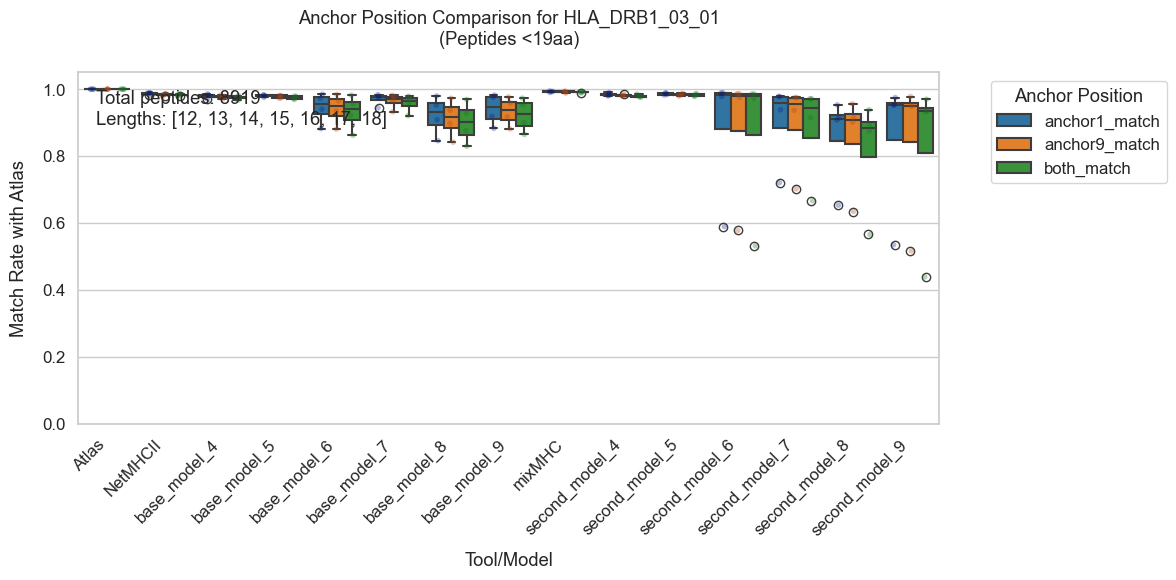

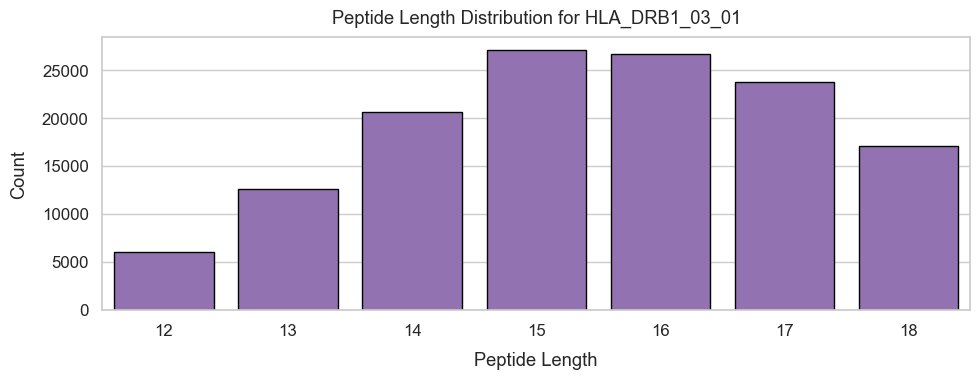

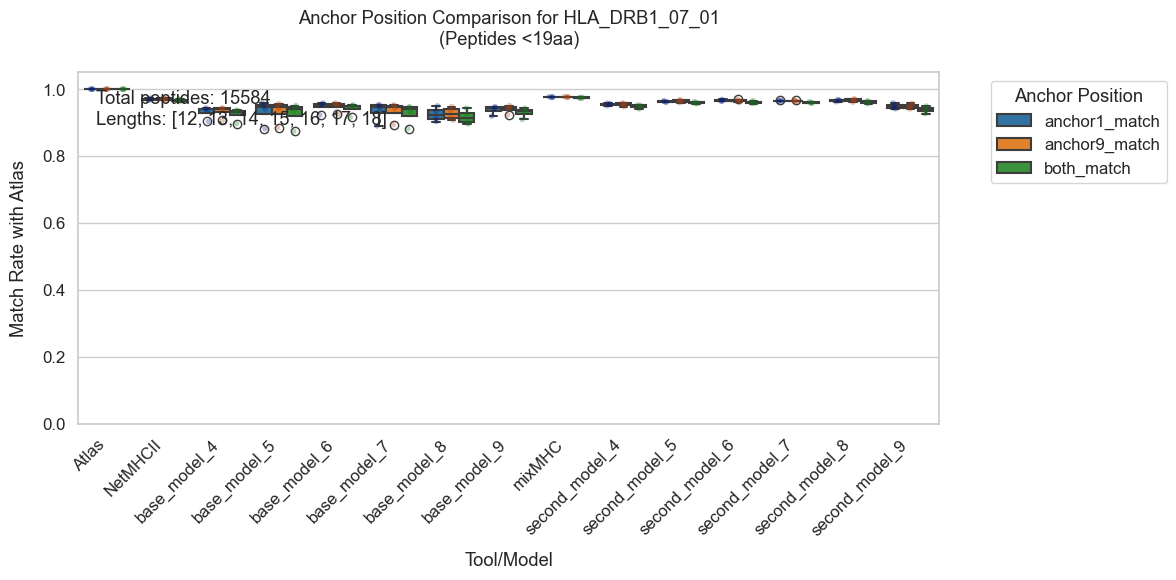

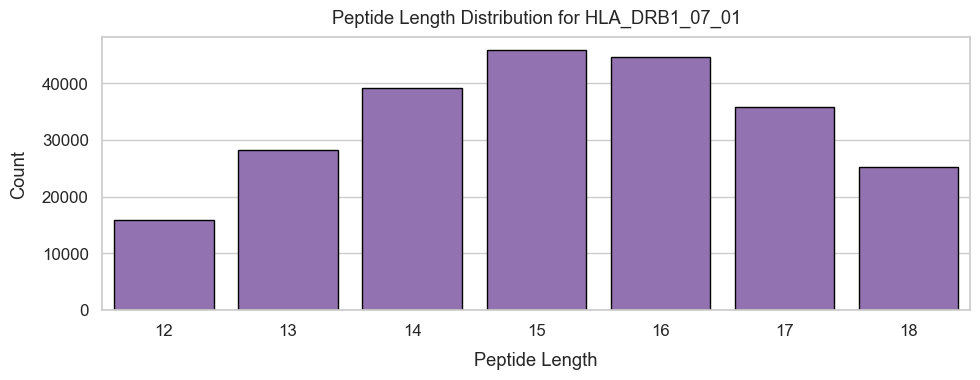

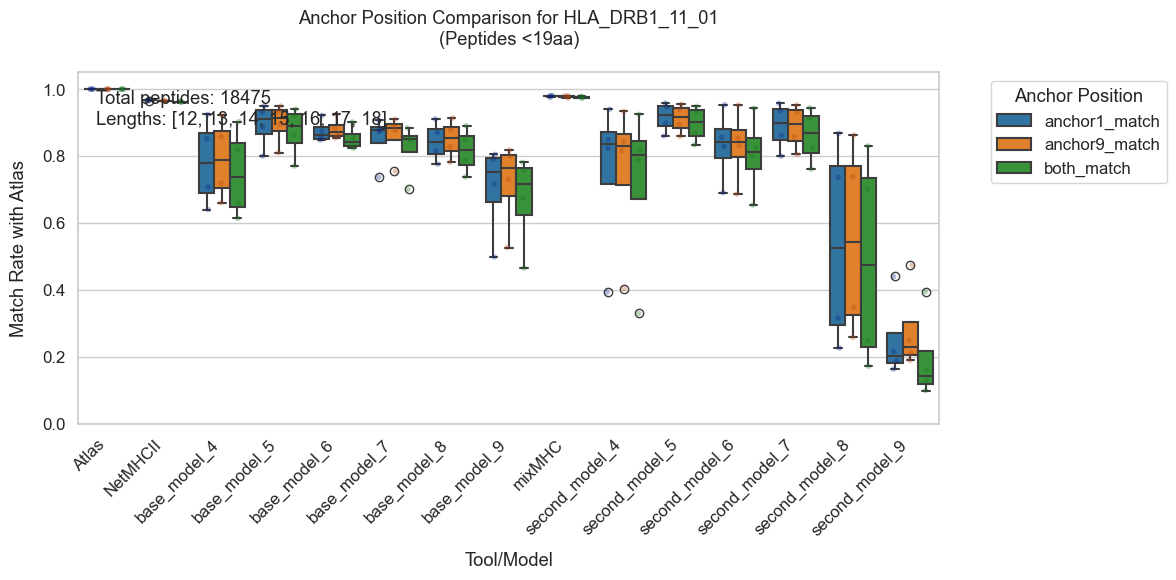

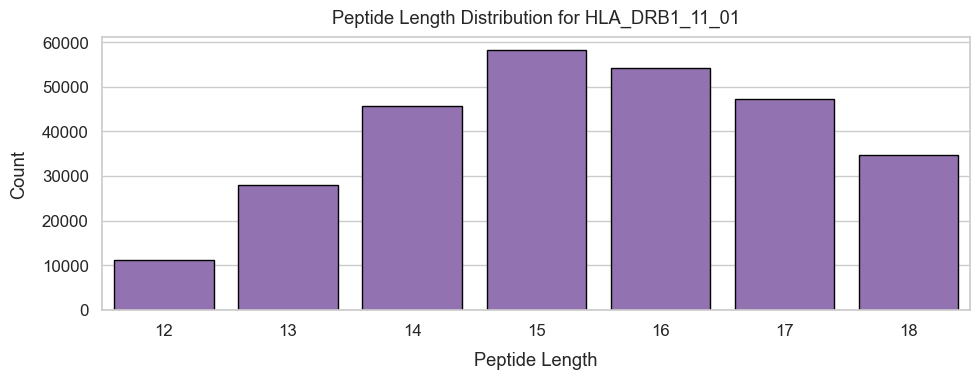

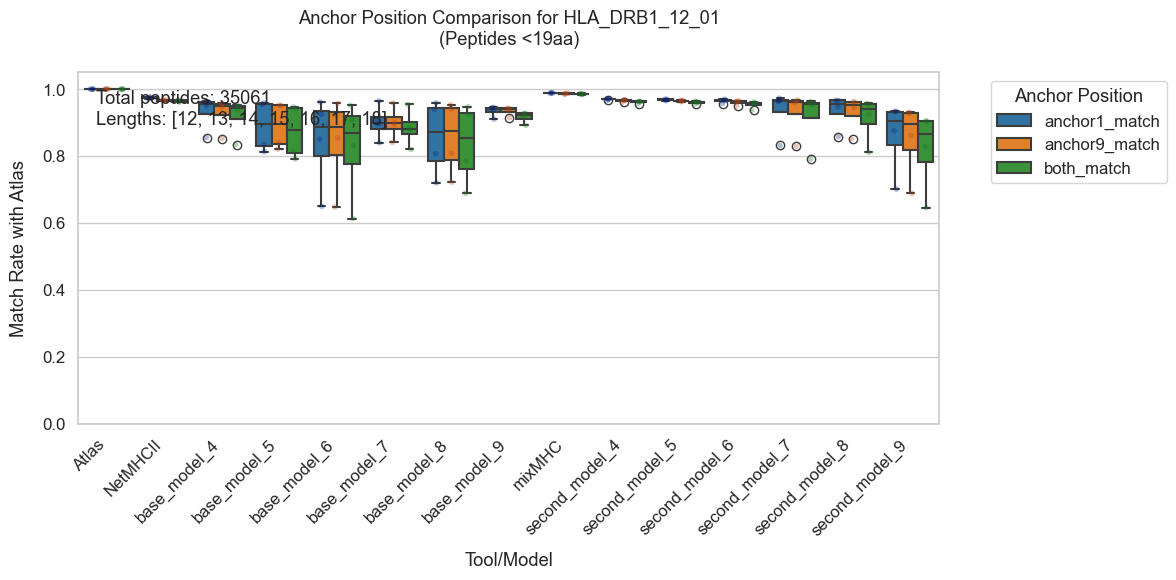

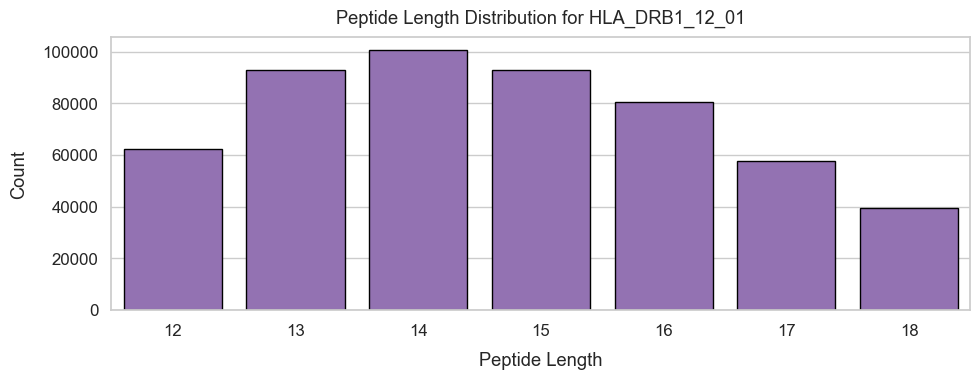

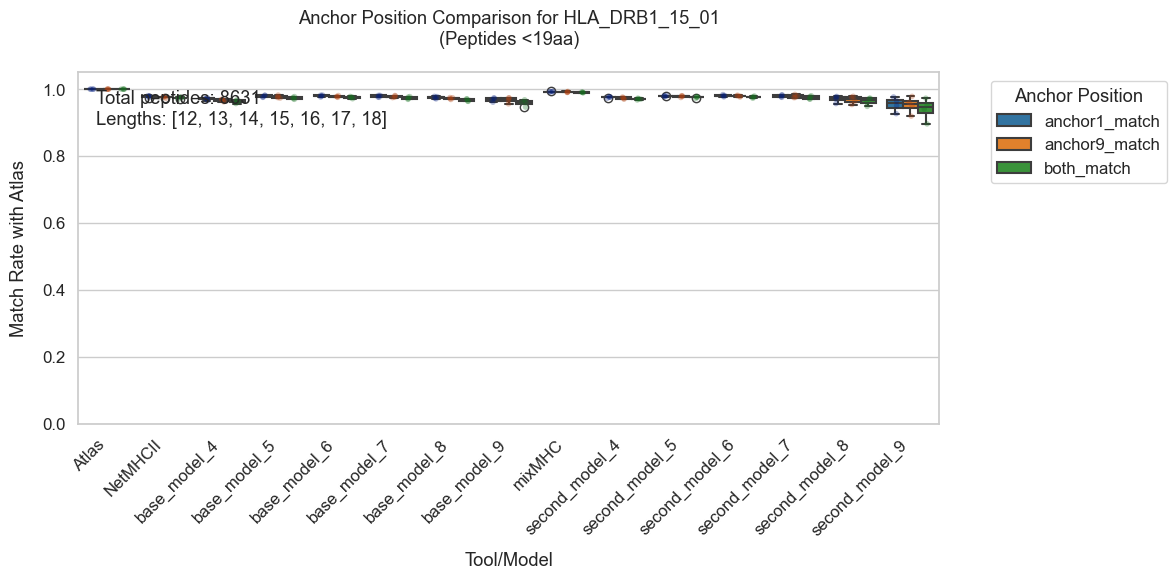

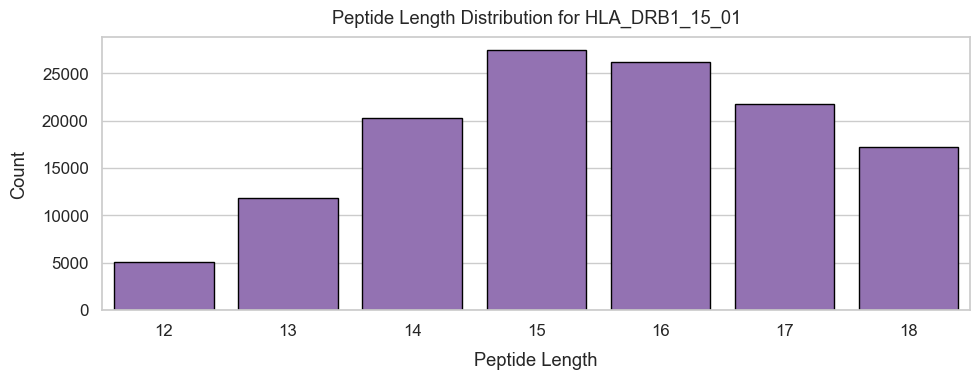

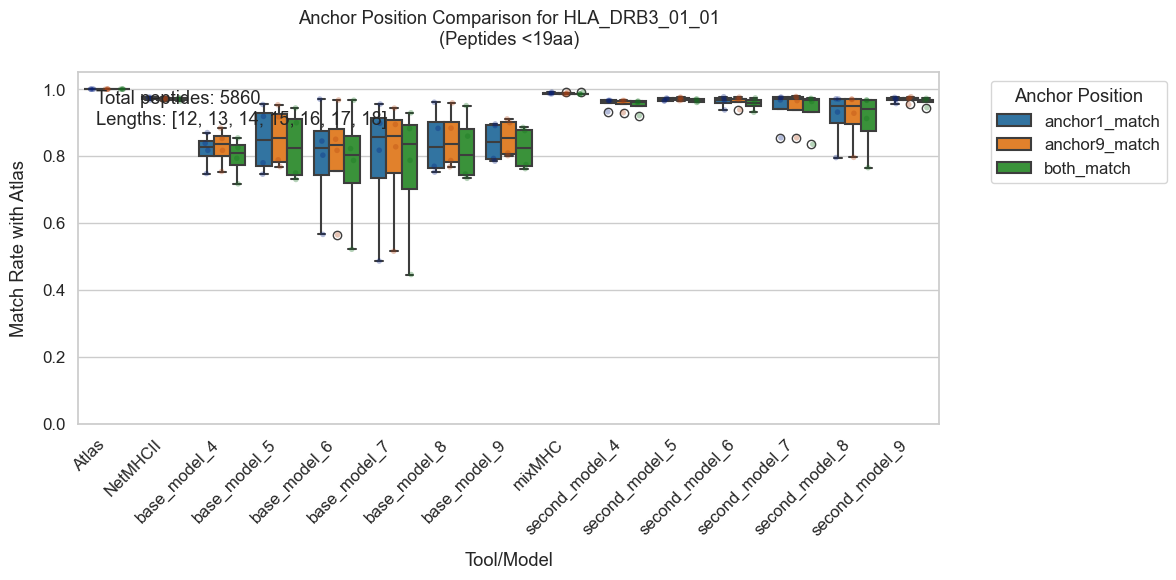

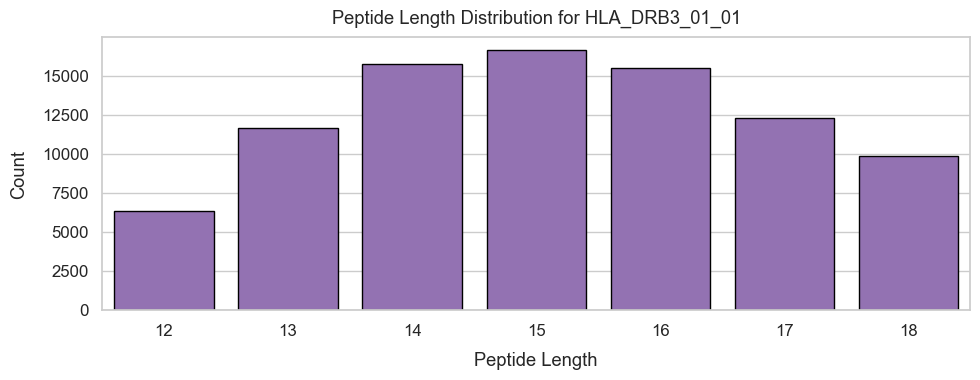

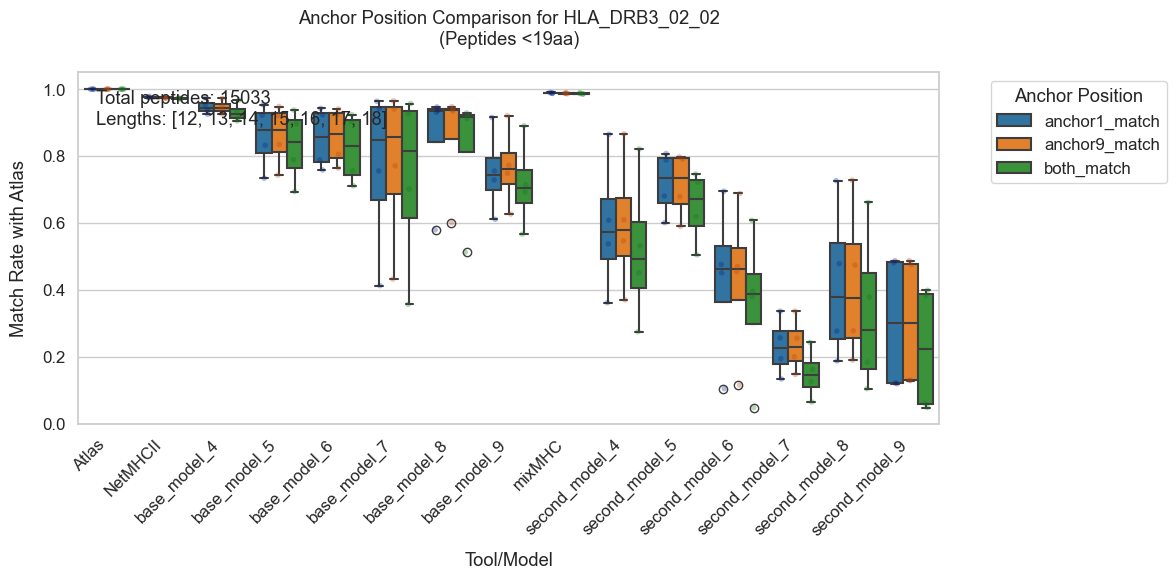

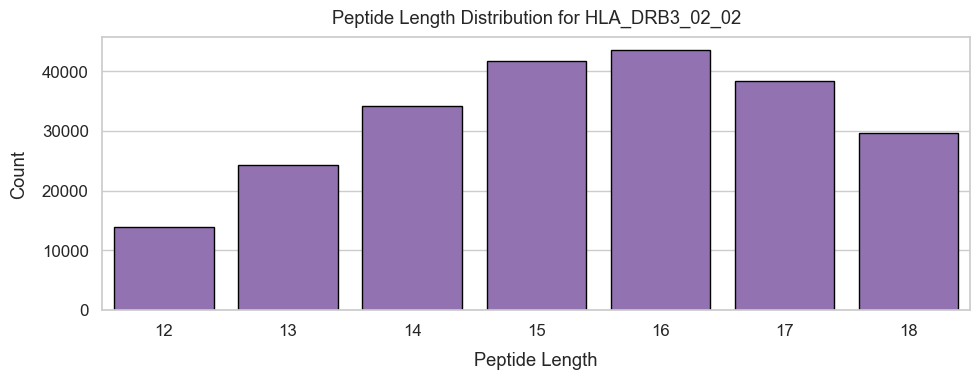

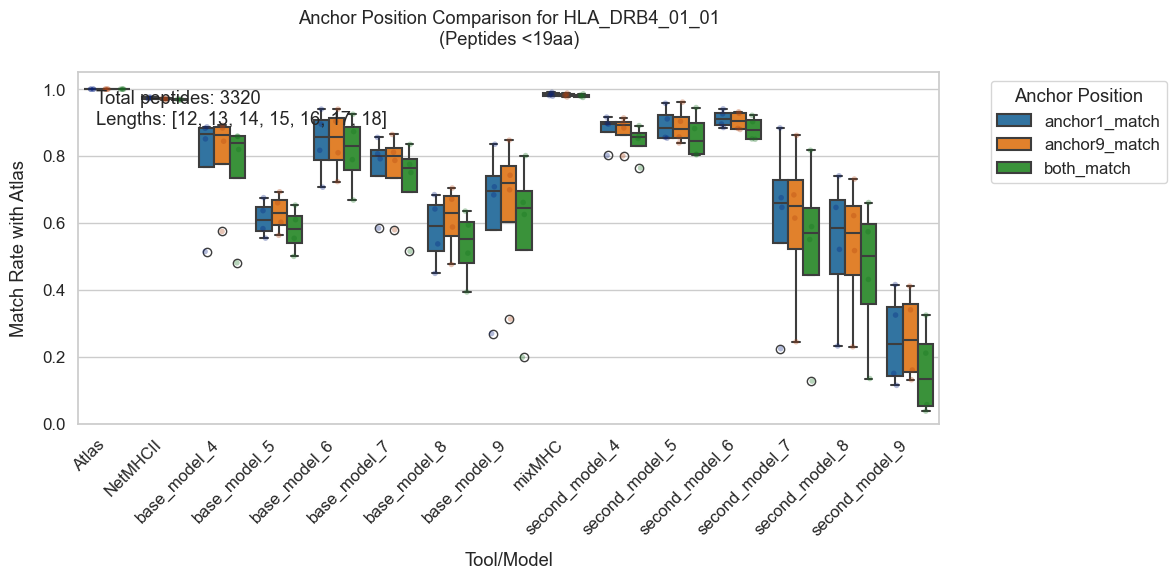

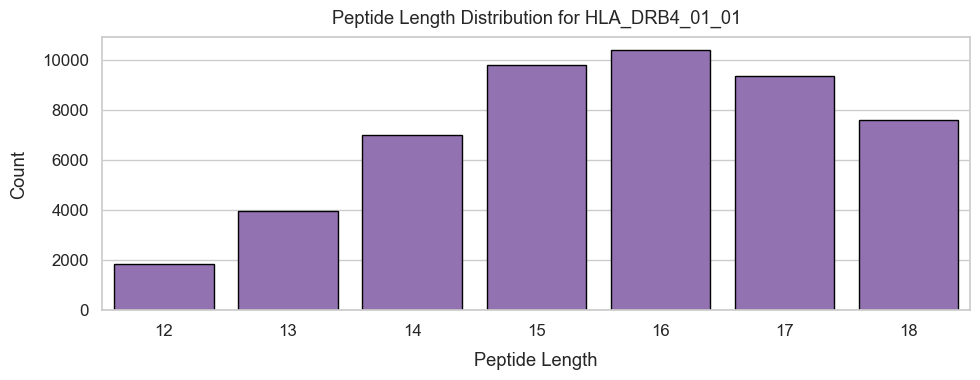


Results saved to: anchor_comparison_results_peptides_lt19.csv


In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, OrderedDict

def standardize_core_dict(core_dict):
    """
    Convert different dictionary formats (OrderedDict, defaultdict) to standard dict
    and ensure consistent nested structure: {allele: {split: {peptide: core}}}
    """
    standardized = {}
    for allele, split_data in core_dict.items():
        standardized[allele] = {}
        if isinstance(split_data, (dict, OrderedDict, defaultdict)):
            for split, peptides in split_data.items():
                if isinstance(peptides, (dict, OrderedDict, defaultdict)):
                    standardized[allele][str(split)] = dict(peptides)
                else:
                    standardized[allele][str(split)] = peptides
        else:
            standardized[allele]['1'] = split_data  # Assume single split if not structured
    return standardized

def compare_anchor_states(reference_cores, tool_cores_dict, max_peptide_length=18):
    """
    Compare anchor states between reference cores and tool cores for peptides <19aa.
    Handles different dictionary formats and standardizes them.
    
    Args:
        reference_cores: Dict of reference cores {allele: {split: {peptide: core}}}
        tool_cores_dict: Dict of tools {tool_name: core_dict}
        max_peptide_length: Maximum peptide length to consider (exclusive)
        
    Returns:
        DataFrame with comparison results
    """
    results = []
    
    # Standardize reference cores
    ref_std = standardize_core_dict(reference_cores)
    
    for tool_name, tool_cores in tool_cores_dict.items():
        # Standardize tool cores
        tool_std = standardize_core_dict(tool_cores)
        
        for allele in ref_std:
            if allele not in tool_std:
                continue
                
            for split in ref_std[allele]:
                if split not in tool_std[allele]:
                    continue
                    
                ref_peptides = ref_std[allele][split]
                tool_peptides = tool_std[allele][split]
                
                for peptide, ref_core in ref_peptides.items():
                    # Skip peptides longer than max_peptide_length
                    if len(peptide) >= max_peptide_length:
                        continue
                        
                    if peptide not in tool_peptides:
                        continue
                        
                    tool_core = tool_peptides[peptide]
                    
                    # Skip if core lengths don't match (should be 9 for DR alleles)
                    if len(ref_core) != 9 or len(tool_core) != 9:
                        continue
                    
                    # Compare anchor positions (positions 1 and 9 for DR)
                    ref_anchor1 = ref_core[0]
                    ref_anchor9 = ref_core[-1]
                    
                    tool_anchor1 = tool_core[0]
                    tool_anchor9 = tool_core[-1]
                    
                    # Calculate matches
                    anchor1_match = ref_anchor1 == tool_anchor1
                    anchor9_match = ref_anchor9 == tool_anchor9
                    both_match = anchor1_match and anchor9_match
                    
                    results.append({
                        'allele': allele,
                        'split': split,
                        'tool': tool_name,
                        'peptide': peptide,
                        'peptide_length': len(peptide),
                        'anchor1_match': int(anchor1_match),
                        'anchor9_match': int(anchor9_match),
                        'both_match': int(both_match),
                        'ref_core': ref_core,
                        'tool_core': tool_core
                    })
    
    return pd.DataFrame(results)

def plot_anchor_comparisons(comparison_df):
    """
    Create boxplots comparing anchor matches across tools for each allele.
    """
    alleles = comparison_df['allele'].unique()
    
    for allele in alleles:
        allele_df = comparison_df[comparison_df['allele'] == allele]
        
        # Calculate match rates per split and tool
        match_rates = allele_df.groupby(['tool', 'split']).agg({
            'anchor1_match': 'mean',
            'anchor9_match': 'mean',
            'both_match': 'mean'
        }).reset_index()
        
        # Melt for plotting
        melted_df = pd.melt(match_rates, 
                          id_vars=['tool', 'split'],
                          value_vars=['anchor1_match', 'anchor9_match', 'both_match'],
                          var_name='anchor_type', 
                          value_name='match_rate')
        
        # Plot settings
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=melted_df, x='tool', y='match_rate', hue='anchor_type',
                   palette={'anchor1_match': '#1f77b4', 
                            'anchor9_match': '#ff7f0e', 
                            'both_match': '#2ca02c'},
                   linewidth=1.5)
        
        # Add stripplot to show individual points
        sns.stripplot(data=melted_df, x='tool', y='match_rate', hue='anchor_type',
                      dodge=True, jitter=0.1, size=4, palette='dark',
                      alpha=0.3, legend=False)
        
        plt.title(f'Anchor Position Comparison for {allele}\n(Peptides <19aa)', pad=20)
        plt.ylabel('Match Rate with Atlas', labelpad=10)
        plt.xlabel('Tool/Model', labelpad=10)
        plt.ylim(0, 1.05)
        plt.legend(title='Anchor Position', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add annotations
        n_peptides = len(allele_df['peptide'].unique())
        plt.text(0.02, 0.95, f'Total peptides: {n_peptides}\nLengths: {sorted(allele_df["peptide_length"].unique())}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Show detailed peptide length distribution
        plt.figure(figsize=(10, 4))
        sns.countplot(data=allele_df, x='peptide_length', 
                     color='#9467bd', edgecolor='black')
        plt.title(f'Peptide Length Distribution for {allele}', pad=10)
        plt.xlabel('Peptide Length', labelpad=10)
        plt.ylabel('Count', labelpad=10)
        plt.tight_layout()
        plt.show()

# Example usage with your specific data formats:
# Assuming you have:
# allele_splits (reference), netmhc_core_sorted (OrderedDict), mixmhc_cores (defaultdict), model_cores_dict

# Prepare all tools dictionary
all_tools = {
    'Atlas': allele_splits,
    'mixMHC': mixmhc_cores,
    'NetMHCII': netmhc_core_sorted,  # Using more descriptive name
    **{exp_name: exp_data for exp_name, exp_data in all_consensus.items()}
}

# Compare anchor states for peptides <19aa
comparison_df = compare_anchor_states(allele_splits, all_tools, max_peptide_length=19)

# Print comprehensive statistics
print("\n" + "="*60)
print("ANALYSIS SUMMARY (PEPTIDES <19aa)")
print("="*60)
print(f"Total comparisons: {len(comparison_df)}")
print(f"Unique peptides: {comparison_df['peptide'].nunique()}")
print("\nPeptide length distribution:")
print(comparison_df['peptide_length'].value_counts().sort_index())
print("\nAlleles analyzed:")
print(comparison_df['allele'].value_counts())
print("\nTools compared:")
print(comparison_df['tool'].value_counts())

# Calculate and print overall match rates
print("\nOverall anchor match rates:")
match_stats = comparison_df.groupby('tool').agg({
    'anchor1_match': 'mean',
    'anchor9_match': 'mean',
    'both_match': 'mean'
})
print(match_stats.round(3))

# Plot results
plot_anchor_comparisons(comparison_df)

# Save comprehensive results
output_file = 'anchor_comparison_results_peptides_lt19.csv'
comparison_df.to_csv(output_file, index=False)
print(f"\nResults saved to: {output_file}")

In [446]:
# Filter out reference tool
filtered_df = comparison_df[comparison_df['tool'] != 'Atlas']

# Group by tool, allele, split and compute mean match values
grouped = filtered_df.groupby(['tool', 'allele', 'split'])[
    ['anchor1_match', 'anchor9_match', 'both_match']
].mean().reset_index()

# Pivot to get split-separated columns
pivot_anchor = grouped.pivot(index=['tool', 'allele'], columns='split')

# Flatten multi-level columns
pivot_anchor.columns = [f"{metric}_split_{split}" for metric, split in pivot_anchor.columns]

# Reset index to get tool and allele as columns
pivot_anchor = pivot_anchor.reset_index().sort_values(by=['tool', 'allele'])



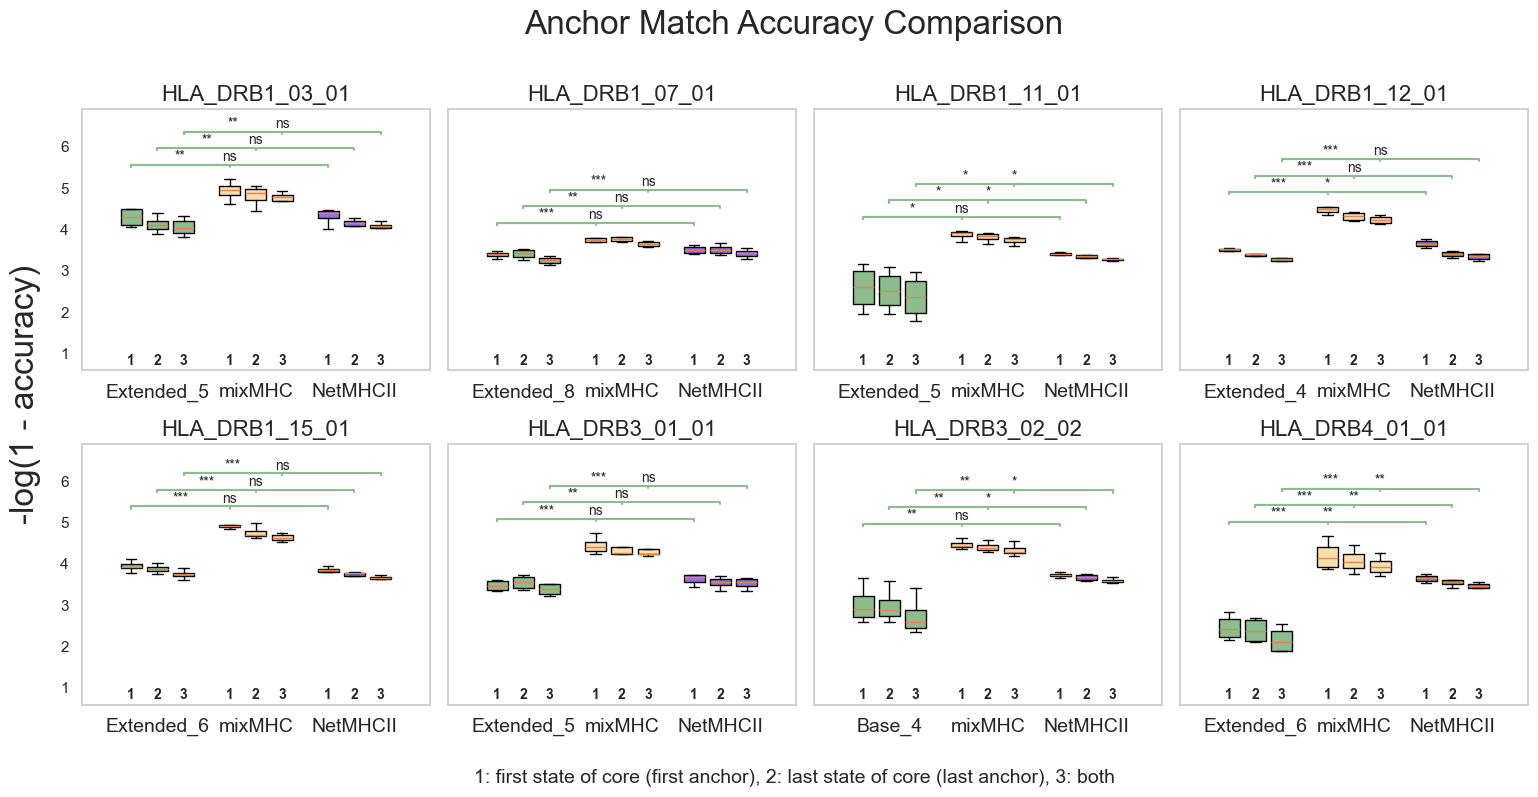

In [550]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

# Function to convert p-value to stars
def pval_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

# Custom palette for consistent coloring
palette = ["darkseagreen", "navajowhite", "mediumpurple"]

# Assuming pivot_anchor is your DataFrame - if not, you'll need to load your data here
# For example:
# pivot_anchor = pd.read_csv('your_data.csv')

# Exclude mixMHC and NetMHCII for best model selection
exclude_methods = ['mixMHC', 'NetMHCII']
filtered_df = pivot_anchor[~pivot_anchor['tool'].isin(exclude_methods)].copy()

# Calculate mean accuracy based on both_match splits for best model selection
filtered_df['mean_accuracy'] = filtered_df[['both_match_split_1', 'both_match_split_2', 
                                          'both_match_split_3', 'both_match_split_4']].mean(axis=1)

# Get best model per allele based on mean of both_match splits
best_models = (
    filtered_df.loc[filtered_df.groupby('allele')['mean_accuracy'].idxmax()]
    .set_index('allele')
)

# Include mixMHC and NetMHCII for comparison
comparison_models = pivot_anchor[pivot_anchor['tool'].isin(['mixMHC', 'NetMHCII'])].copy()

# Prepare layout
alleles = best_models.index.unique()
n_alleles = len(alleles)
n_cols = 4
n_rows = (n_alleles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust spacing between subplots

# Flatten axes array for easier iteration
axes = axes.flatten()

for ax in axes:
    ax.set_ylim(0.6, 6.9)

all_plots_data = []

for idx, allele in enumerate(alleles):
    ax = axes[idx]
    best_row = best_models.loc[allele]
    best_method = best_row['tool']
    
    # Prepare data for all three match types
    data = []
    
    # For each match type (anchor1, anchor9, both)
    for match_type in ['anchor1', 'anchor9', 'both']:
        # Get best model scores
        best_scores = best_row[[f'{match_type}_match_split_1', f'{match_type}_match_split_2',
                               f'{match_type}_match_split_3', f'{match_type}_match_split_4']].values.astype(float)
        data.extend([(f"{match_type}_{best_method}", s) for s in best_scores])
        
        # Get comparison scores (mixMHC and NetMHCII)
        for method in ['mixMHC', 'NetMHCII']:
            row_match = comparison_models[(comparison_models['allele'] == allele) & (comparison_models['tool'] == method)]
            if not row_match.empty:
                scores = row_match.iloc[0][[f'{match_type}_match_split_1', f'{match_type}_match_split_2',
                                          f'{match_type}_match_split_3', f'{match_type}_match_split_4']].values.astype(float)
                data.extend([(f"{match_type}_{method}", s) for s in scores])

    plot_df = pd.DataFrame(data, columns=['Method', 'Accuracy'])
    plot_df[['Match_Type', 'Tool']] = plot_df['Method'].str.split('_', n=1, expand=True)
    plot_df['Log_Accuracy'] = -np.log(1 - plot_df['Accuracy'] + 1e-6)

    all_plots_data.append((ax, plot_df, best_method, allele))

palette_dict = {
    'mixMHC': "navajowhite",
    'NetMHCII': "mediumpurple"
}

for ax, plot_df, best_method, allele in all_plots_data:
    # Create display names for models
    display_names = {
        best_method: best_method.replace("second_model", "Extended").replace("base_model", "Base"),
        'mixMHC': 'mixMHC',
        'NetMHCII': 'NetMHCII'
    }
    
    # Create a subplot for each match type
    match_types = ['anchor1', 'anchor9', 'both']
    
    # Calculate positions for grouped bars
    n_methods = 3  # best_method, mixMHC, NetMHCII
    n_match_types = len(match_types)
    total_width = 0.8
    bar_width = total_width / n_match_types
    
    # Get max y-value for significance bars
    max_y = plot_df['Log_Accuracy'].max()
    
    # Create positions for each group
    positions = np.arange(n_methods)
    
    # Create a small offset for each match type within the group
    offsets = np.linspace(-total_width/2 + bar_width/2, total_width/2 - bar_width/2, n_match_types)
    
    # Plot each match type
    for match_idx, match_type in enumerate(match_types):
        # Filter data for this match type
        match_data = plot_df[plot_df['Match_Type'] == match_type]
        
        # Get methods present for this match type
        methods_present = [f"{match_type}_{best_method}", f"{match_type}_mixMHC", f"{match_type}_NetMHCII"]
        methods_present = [m for m in methods_present if m in match_data['Method'].unique()]
        
        # Get actual tool names (without match type prefix)
        tool_names = [m.split('_', 1)[1] for m in methods_present]
        
        # Assign colors
        colors = []
        for tool in tool_names:
            if tool == best_method:
                colors.append("darkseagreen")
            else:
                colors.append(palette_dict[tool])
        
        # Calculate positions for this match type
        pos = positions + offsets[match_idx]
        
        # Plot boxplot
        box = ax.boxplot(
            [match_data[match_data['Method'] == m]['Log_Accuracy'] for m in methods_present],
            positions=pos,
            widths=bar_width*0.8,
            patch_artist=True,
            showfliers=False
        )
        
        # Set colors
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
        
        # Add match type numbers above each boxplot
        for i, (x_pos, tool) in enumerate(zip(pos, tool_names)):
            ax.text(x_pos, ax.get_ylim()[0] + 0.4, str(match_idx+1),  # Changed y-position to below
                   ha='center', va='top', fontsize=10, fontweight='bold')  # Changed va to 'top'
        
        # Add significance stars between best method and others
        best_method_full = f"{match_type}_{best_method}"
        if best_method_full in methods_present:
            best_idx = methods_present.index(best_method_full)
            best_scores = match_data[match_data['Method'] == best_method_full]['Log_Accuracy']
            
            for i, method in enumerate(methods_present):
                if i != best_idx:
                    other_scores = match_data[match_data['Method'] == method]['Log_Accuracy']
                    pval = ttest_ind(best_scores, other_scores, equal_var=False).pvalue
                    stars = pval_to_stars(pval)
                    
                    # Draw line and add stars
                    y_pos = max_y + 0.3 + 0.4 * match_idx
                    h = 0.05
                    
                    x1 = pos[best_idx]
                    x2 = pos[i]

                    ax.plot([x1, x1, x2, x2], [y_pos, y_pos + h, y_pos + h, y_pos], lw=1.5, color="darkseagreen")
                    ax.text((x1 + x2) / 2, y_pos + h + 0.02, stars, ha='center', va='bottom', fontsize=10)
    
    # Set x-ticks and labels using display names
    ax.set_xticks(positions)
    ax.set_xticklabels([display_names[best_method], display_names['mixMHC'], display_names['NetMHCII']], fontsize=14)
    
    ax.set_title(allele, fontsize=16)
    ax.grid(False)

# Turn off unused axes
for i in range(n_alleles, len(axes)):
    axes[i].axis('off')

# Shared y-label
fig.text(0.01, 0.5, '-log(1 - accuracy)', va='center', rotation='vertical', fontsize=24)

# Add common legend at the bottom center
legend_text = "1: first state of core (first anchor), 2: last state of core (last anchor), 3: both"
fig.text(0.5, 0.02, legend_text, ha='center', va='center', fontsize=14)

# Main title
fig.suptitle("Anchor Match Accuracy Comparison", fontsize=24, y=0.98)

plt.tight_layout(rect=[0.03, 0.05, 0.97, 0.97])  # Adjusted margins
plt.savefig(f"plots//Anchor_Match.png", dpi=300)
plt.show()



